In [1]:
import os
if not 'chdir' in globals():
    os.chdir('..')
    chdir = True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots import bundles
import src.colorednoise as cn
from scipy.stats import norm
from exp.plotting import init_plotting
from src.utils import bootstrap_average, get_env2best_beta, get_env2worst_beta, ou_gaussian_as_beta, normalize_group, plot, get_box
from tqdm.notebook import tqdm, trange
from src.oscillator import OscillatorEnv
from scipy.signal import welch
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import PercentFormatter
from PIL import Image
from matplotlib import mlab
from matplotlib.lines import Line2D

In [3]:
init_plotting(publish=True)
latex = plt.rcParams['text.latex.preamble']

# plt.style.use(('science', 'grid'))

plt.rcParams.update(bundles.neurips2022())
plt.rcParams['text.latex.preamble'] = latex + plt.rcParams['text.latex.preamble']
W, _ = plt.rcParams['figure.figsize']

# plt.rcParams['grid.alpha'] = 0.2

In [4]:
data = pd.read_csv('dat/data.csv')
oudata = pd.read_csv('exp/paper/data.csv')

betas = data.beta.dropna().unique()

In [5]:
colors = {
    'WN': '#00BFA0',
    'Pink': '#DC0AB4',
    'OU': '#FFA300'
}

In [8]:
envs = {
    'pendulum': 'Pendulum',
    'cart-pole': 'CartPole',
    'ball-in-cup': 'Ball-In-Cup',
    'mc': 'MountainCar',
    'hopper': 'Hopper',
    'walker': 'Walker',
    'reacher': 'Reacher',
    'cheetah': 'Cheetah',
    'door': 'Door'
}

In [6]:
def get_ou(N, T, theta=0.15, dt=1e-2, sigma='norm', rng=None):
    """Direct discretisation of the SDE."""
    if sigma == 'norm':
        sigma = np.sqrt((1 - (1 - theta*dt)**2) / dt)
    x = norm.rvs(0, 1, (N, T), random_state=rng)
    y = np.zeros((N, T+1))
    for i in range(1, T+1):
        y[:, i] = y[:, i - 1] - dt*theta*y[:, i - 1] + sigma*np.sqrt(dt)*x[:, i-1]
    return y[:, 1:]

---
# Main paper

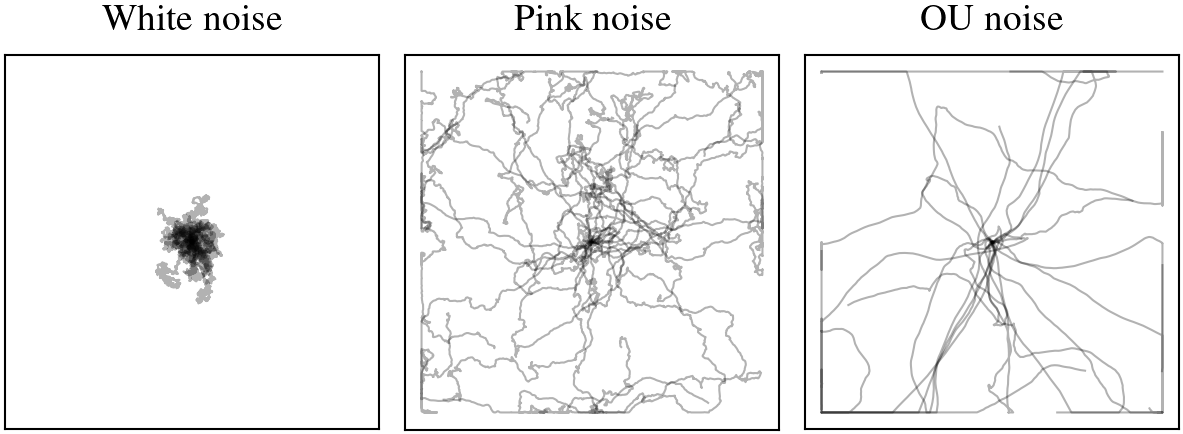

In [7]:
rng = np.random.default_rng(6)

N = 20
T = 1000
c = 250

fig, ax = plt.subplots(1, 3, figsize=(4, 2), constrained_layout=True, sharex=True, sharey=True)
ax[0].set_title('White noise')
ax[1].set_title('Pink noise')
ax[2].set_title('OU noise')
for i, b in enumerate([0, 1, 'ou']):
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')
    if b == 'ou':
        a_x = get_ou(N, T, rng=rng)
        a_y = get_ou(N, T, rng=rng)
    else:
        a_x = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
        a_y = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)

    x = np.zeros_like(a_x)
    y = np.zeros_like(a_y)
    for t in range(1, T):
        x[:, t] = np.clip(x[:, t-1] + a_x[:, t], -c, c)
        y[:, t] = np.clip(y[:, t-1] + a_y[:, t], -c, c)
        
    for j in range(N):
        ax[i].plot(x[j], y[j], 'k', alpha=0.3, lw=0.5)

fig.savefig('doc/paper/fig/trajectories.pdf')

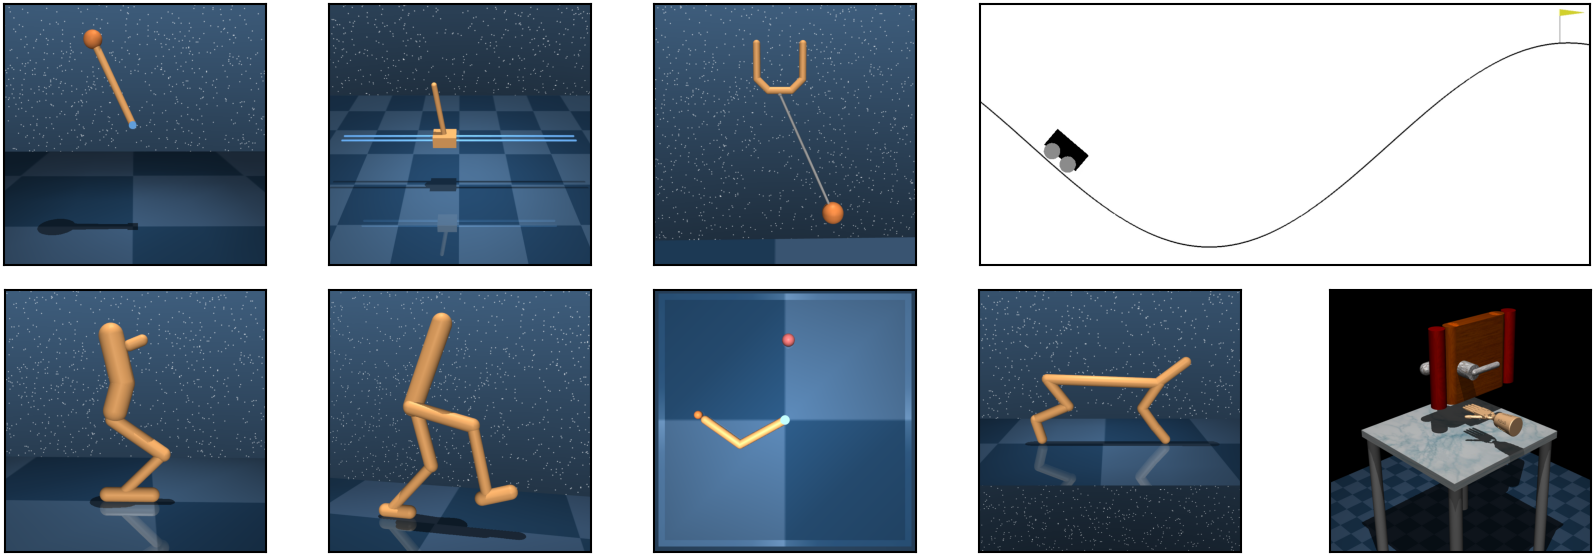

In [9]:
fig, ax = plt.subplot_mosaic([['pendulum', 'cart-pole', 'ball-in-cup', 'mc', 'mc'], ['hopper', 'walker', 'reacher', 'cheetah', 'door']], figsize=(W, W/2.88))
for n, x in ax.items():
    # x.set_title(envs[n])
    x.set_xticks([])
    x.set_yticks([])
    x.grid(False)
    im = Image.open(f"exp/paper/envs/{n}.png")
    x.imshow(im)
fig.savefig('doc/paper/fig/envs.pdf', dpi=1000)

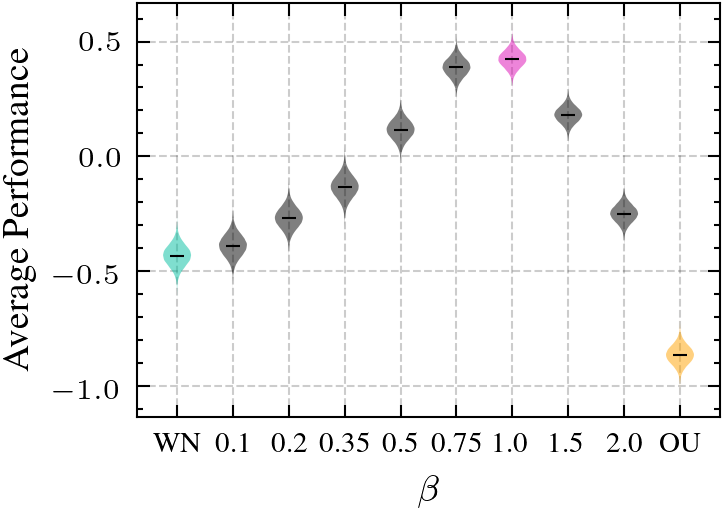

In [6]:
# Normalize data
consdata = data.query("agent != 'td3'")
normdata = normalize_group(consdata, ['env', 'agent'], ignore_column=['beta', 'seed', 'sigma'])

betas = data.beta.dropna().unique()[1:]

# Bootstrapping
N = 100_000
S = 20
xs = []
xs.append(bootstrap_average(normdata.query("noise == 'wn'"), N=N*20).reshape(N, 20).mean(axis=1))
for beta in betas:
    xs.append(bootstrap_average(normdata.query(f"noise == 'constant' and beta == {beta}"), N=N*20).reshape(N, 20).mean(axis=1))
xs.append(bootstrap_average(normdata.query("noise == 'ou'"), N=N*20).reshape(N, 20).mean(axis=1))

fig, ax = plt.subplots(figsize=(0.45*W, 0.45*W/1.4))
ax.set_ylabel("Average Performance")
ax.set_xlabel(r"$\beta$")
violins = ax.violinplot(xs, showmeans=True, showextrema=False) #, quantiles=[[0.025, 0.975]]*len(xs), showextrema=False) #, labels=['WN'] + list(betas) + ['OU'], showfliers=False)

violins['cmeans'].set_edgecolor('k')
violins['cmeans'].set_linewidth(0.5)

for v in violins['bodies']:
    v.set_facecolor('k')
    v.set_alpha(0.5)

violins['bodies'][0].set_facecolor(colors['WN'])
violins['bodies'][6].set_facecolor(colors['Pink'])
violins['bodies'][-1].set_facecolor(colors['OU'])

ax.set_xticks(range(1, len(betas)+3))
ax.set_xticklabels(['WN'] + list(betas) + ['OU'])
ax.xaxis.set_minor_locator(plt.NullLocator())

fig.savefig('doc/paper/fig/allbeta.pdf')
plt.show()

In [30]:
# Normalize data
consdata = data.query("agent != 'td3'")
normdata = normalize_group(consdata, ['env', 'agent'], ignore_column=['beta', 'seed', 'sigma'])

betas = data.beta.dropna().unique()[1:]

data_og = ou_gaussian_as_beta(data, set_noise_constant=True)
data_og.beta = data_og.beta.apply(str)
# consdata_og = data_og.query("noise == 'constant' and agent != 'td3'")
consdata_og = data_og.query("agent != 'td3'")
normdata_og = normalize_group(consdata_og, ['env', 'agent'], ignore_column=['beta', 'seed', 'sigma'])
normdata_og = normdata_og.query("noise == 'constant'")

env_to_best_beta = get_env2best_beta(normdata_og.query("seed < 10"), aggregation_method="mean")
env_to_worst_beta = get_env2worst_beta(normdata_og.query("seed < 10"), aggregation_method="mean")
df_best_beta_ratios = normdata_og.query("seed >=10")

df_best_betas = df_best_beta_ratios[[row.beta == env_to_best_beta[row.env]["beta"] for idx, row in df_best_beta_ratios.iterrows()]]
df_worst_betas = df_best_beta_ratios[[row.beta == env_to_worst_beta[row.env]["beta"] for idx, row in df_best_beta_ratios.iterrows()]]


env_to_best_beta2 = get_env2best_beta(normdata_og.query("seed >= 10"), aggregation_method="mean")
env_to_worst_beta2 = get_env2worst_beta(normdata_og.query("seed >= 10"), aggregation_method="mean")
df_best_beta_ratios2 = normdata_og.query("seed < 10")

df_best_betas2 = df_best_beta_ratios2[[row.beta == env_to_best_beta2[row.env]["beta"] for idx, row in df_best_beta_ratios2.iterrows()]]
df_worst_betas2 = df_best_beta_ratios2[[row.beta == env_to_worst_beta2[row.env]["beta"] for idx, row in df_best_beta_ratios2.iterrows()]]

df_best_betas_cat = pd.concat([df_best_betas, df_best_betas2])
df_worst_betas_cat = pd.concat([df_worst_betas, df_worst_betas2])

expected_best_beta = df_best_betas_cat.perf.mean()
expected_worst_beta = df_worst_betas_cat.perf.mean()
span = expected_best_beta - expected_worst_beta

normdata['gain'] = (normdata.perf - expected_worst_beta) / span
df_worst_betas_cat['gain'] = (df_worst_betas_cat.perf - expected_worst_beta) / span
df_best_betas_cat['gain'] = (df_best_betas_cat.perf - expected_worst_beta) / span

/Users/onno/mpi/cnrl/src/utils.py:94: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seed_aggregated = dataframe.groupby(["env", "beta"]).agg(aggregation_method).reset_index()
/Users/onno/mpi/cnrl/src/utils.py:101: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seed_aggregated = dataframe.groupby(["env", "beta"]).agg(aggregation_method).reset_index()
/Users/onno/mpi/cnrl/src/utils.py:94: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for th

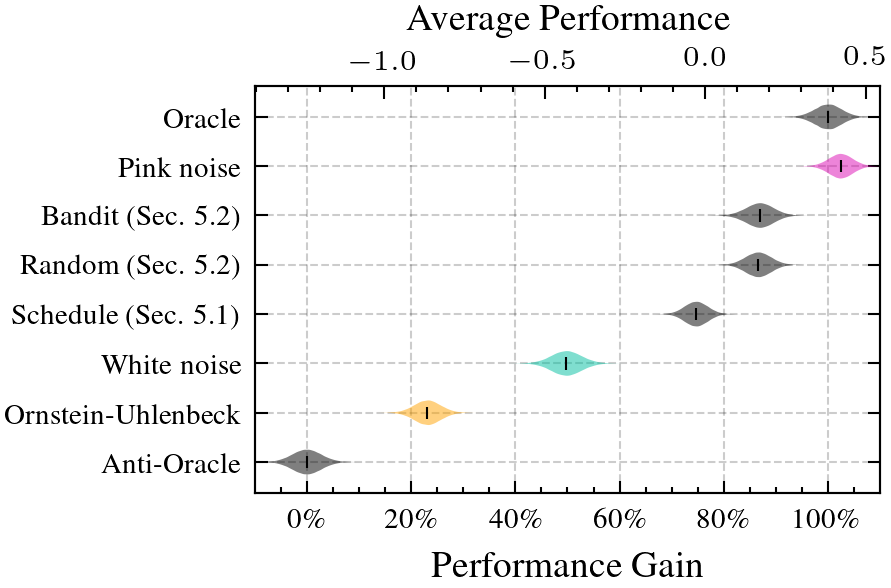

In [31]:
N = 100_000

fig, ax = plt.subplots(figsize=(1.1*W/2, 1.1*W/3))
ax.set_xlabel("Performance Gain")
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

ax2 = ax.twiny()    # for gain over worst
ax2.set_xlabel("Average Performance")
ax2.grid(False)
def convert_ax2(ax1):
    y1, y2 = ax1.get_xlim()
    # (normdata.perf - expected_worst_beta) / span
    ax2.set_xlim(y1*span + expected_worst_beta, y2*span + expected_worst_beta)
    # ax2.set_xlim(y1, y2)
    ax2.figure.canvas.draw()
ax.callbacks.connect("xlim_changed", convert_ax2)   


violins = ax.violinplot([
    bootstrap_average(df_worst_betas_cat, N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'ou'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'wn'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'schedule' and method == 'linear'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'random' and method == 'list'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'bandit' and method == 'return-list'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(normdata.query("noise == 'constant' and beta == 1"), N=N*20, value='gain').reshape(N, 20).mean(axis=1),
    bootstrap_average(df_best_betas_cat, N=N*20, value='gain').reshape(N, 20).mean(axis=1),
], showmeans=True, vert=False, showextrema=False)#, labels=['OU', 'WN', 'Schedule', 'Random', 'Bandit', 'PN'], showfliers=False)

violins['cmeans'].set_edgecolor('k')
violins['cmeans'].set_linewidth(0.5)

for v in violins['bodies']:
    v.set_facecolor('k')
    v.set_alpha(0.5)

violins['bodies'][1].set_facecolor(colors['OU'])
violins['bodies'][2].set_facecolor(colors['WN'])
violins['bodies'][-2].set_facecolor(colors['Pink'])

ax.set_xlim(-0.1, 1.1)


ax.set_yticks(range(1, 9))
ax.set_yticklabels(['Anti-Oracle', 'Ornstein-Uhlenbeck', 'White noise', 'Schedule (Sec. 5.1)', 'Random (Sec. 5.2)', 'Bandit (Sec. 5.2)', 'Pink noise', 'Oracle'])
ax.yaxis.set_minor_locator(plt.NullLocator())


fig.savefig('doc/paper/fig/compare.pdf')
plt.show()

In [32]:
# WN and OU vs Oracle.
print(round(bootstrap_average(normdata.query("noise == 'ou'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1).mean(), 2))
print(round(bootstrap_average(normdata.query("noise == 'wn'"), N=N*20, value='gain').reshape(N, 20).mean(axis=1).mean(), 2))

0.23
0.5


In [9]:
# Read in precomputed data for bounded integrator and oscillator.
z = np.load('dat/energy.npy')
H = np.load('dat/H.npy')
me = np.load('dat/cos.npy')

C = 200
F = 200
cs = np.logspace(np.log10(25), np.log10(1000), C)
E = np.logspace(np.log10(1/4000), np.log10(1/2), F)

In [16]:
# Code to compute bounded integrator data (takes some time)
def entropy(p):
    return -np.nansum(p * np.log(p))

rng = np.random.default_rng(42)

N = 10_000
T = 1000
H = np.zeros((3, C))

for i, b in enumerate([0, 1, 'ou']):
    for j, c in tqdm(enumerate(cs), total=C):
        if b == 'ou':
            a_x = get_ou(N, T, rng=rng)
            a_y = get_ou(N, T, rng=rng)
        else:
            a_x = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
            a_y = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
        
        x = np.zeros((N, T))
        y = np.zeros((N, T))

        for t in range(1, T):
            x[:, t] = np.clip(x[:, t-1] + a_x[:, t], -c, c)
            y[:, t] = np.clip(y[:, t-1] + a_y[:, t], -c, c)
        
        h = np.histogram2d(x.ravel(), y.ravel(), bins=50, range=[[-c, c], [-c, c]])[0]
        h /= h.sum()
        H[i, j] = entropy(h)

np.save('dat/H.npy', H)

  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/nh/02c5_5bn2k97xpljx3m07hrm0000gn/T/ipykernel_8898/3650870626.py:3: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(p))
/var/folders/nh/02c5_5bn2k97xpljx3m07hrm0000gn/T/ipykernel_8898/3650870626.py:3: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(p))


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
# Code to compute oscillator data (takes some time)
rng = np.random.default_rng(42)

N = 1000
T = 1000
z = np.zeros((3, F, T, N))
me = np.zeros((F, T))

# Noisy excitation
for k, f in tqdm(enumerate(E), total=F):
    osc = OscillatorEnv(frequency=f, target=None, initial_state=(0, 0), max_steps=T, res=0, dt=1)
    for i, b in enumerate([0, 1, 'ou']):
        if b == 'ou':
            a = get_ou(N, T, rng=rng)
        else:
            a = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
        for j in range(N):
            x, y = osc.reset()
            z[i, k, 0, j] = osc.energy(osc.state)
            for t in range(1, T):
                *_, info = osc.step([a[j, t]])
                z[i, k, t, j] = info['energy']

# Cosine excitation
for k, f in enumerate(E):
    osc = OscillatorEnv(frequency=f, target=None, initial_state=(0, 0), max_steps=T, res=0, dt=1)
    a = np.cos(2 * np.pi * f * np.arange(T))
    osc.reset()
    me[k, 0] = 0
    for t in range(1, T):
        *_, info = osc.step([a[t]])
        me[k, t] = info['energy']

np.save('dat/energy.npy', z)
np.save('dat/cos.npy', me)

  0%|          | 0/200 [00:00<?, ?it/s]

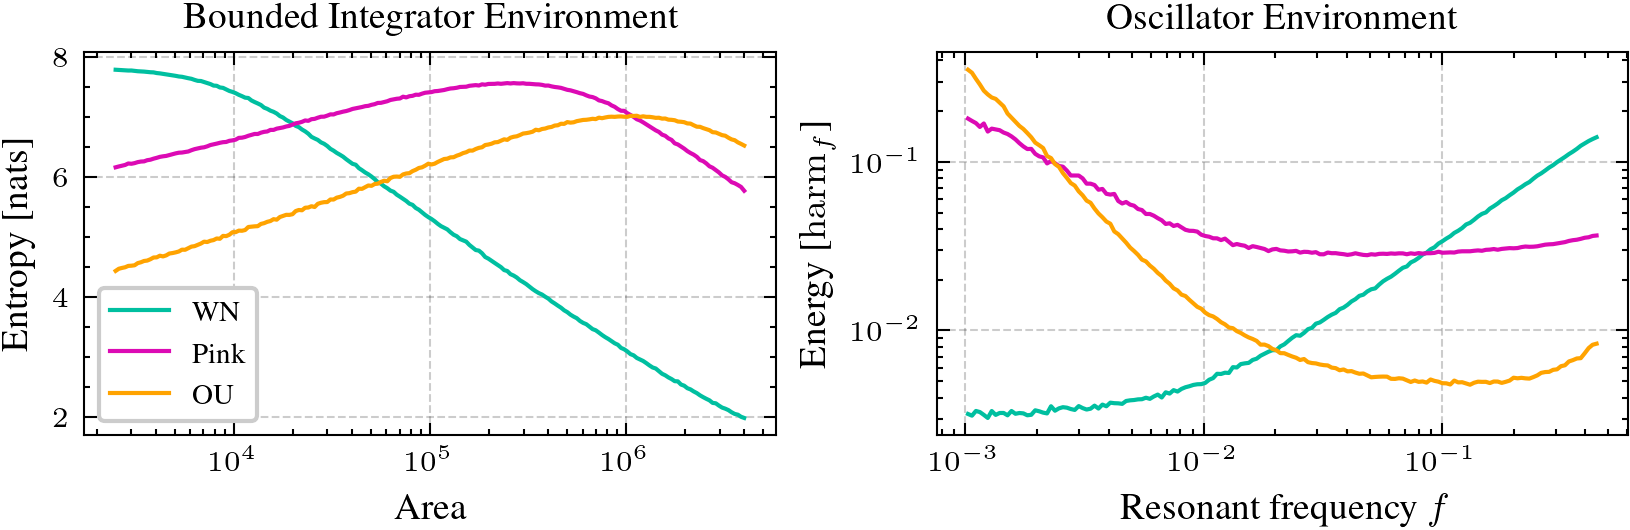

In [11]:
# W = 5.8
fig, ax = plt.subplots(1, 2, figsize=(W, W/3))
ax[0].set_title("Bounded Integrator Environment")
ax[0].set_ylabel("Entropy [nats]")
ax[0].set_xlabel(r"Area")
for i, n in enumerate(["WN", "Pink", "OU"]):
    ax[0].semilogx((2*cs)**2, H[i], label=f'{n}', color=colors[n])
ax[0].legend(frameon=True)

ax[1].set_title("Oscillator Environment")
ax[1].set_ylabel(r"Energy [$\operatorname{harm}_f$]")
ax[1].set_xlabel('Resonant frequency $f$')
for i, n in enumerate(["WN", "Pink", "OU"]):
    ax[1].loglog(E[E >= 1e-3][:-3], (z[i].mean((1, 2)) / me.mean(-1))[E >= 1e-3][:-3], label=f'{n}', color=colors[n])

fig.savefig('doc/paper/fig/entropy-energy.pdf')

---
# Appendix

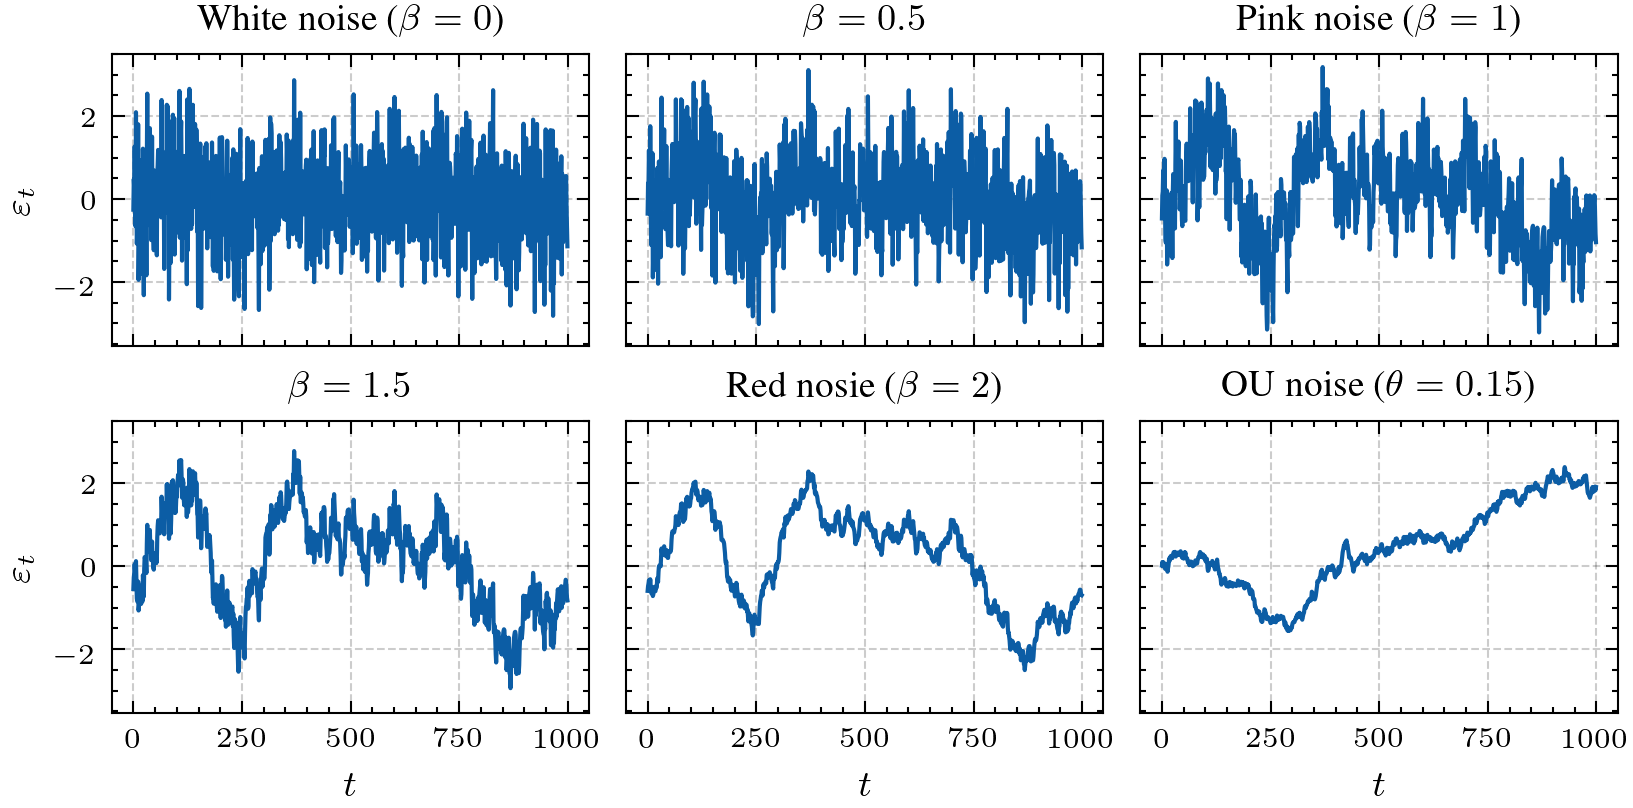

In [73]:
fig, ax = plt.subplots(2, 3, figsize=(W, W/2), sharex=True, sharey=True)
a = ax.ravel()

ax[0, 0].set_ylabel(r"$\varepsilon_t$")
ax[1, 0].set_ylabel(r"$\varepsilon_t$")
ax[1, 0].set_xlabel(r"$t$")
ax[1, 1].set_xlabel(r"$t$")
ax[1, 2].set_xlabel(r"$t$")

n = [r'White noise ($\beta = 0$)', r'$\beta = 0.5$', r'Pink noise ($\beta = 1$)', r'$\beta = 1.5$', r'Red nosie ($\beta = 2$)', r'OU noise ($\theta = 0.15$)']
beta = [0, 0.5, 1, 1.5, 2, 'ou']

rng_ou = np.random.default_rng(21)
for i in range(6):
    rng = np.random.default_rng(42)
    a[i].set_title(n[i])
    if beta[i] == 'ou':
        x = get_ou(1, 1000, rng=rng_ou)[0]
    else:
        x = cn.powerlaw_psd_gaussian(beta[i], 1000, rng=rng)
    a[i].plot(x)

fig.savefig('doc/paper/fig/noises.pdf')

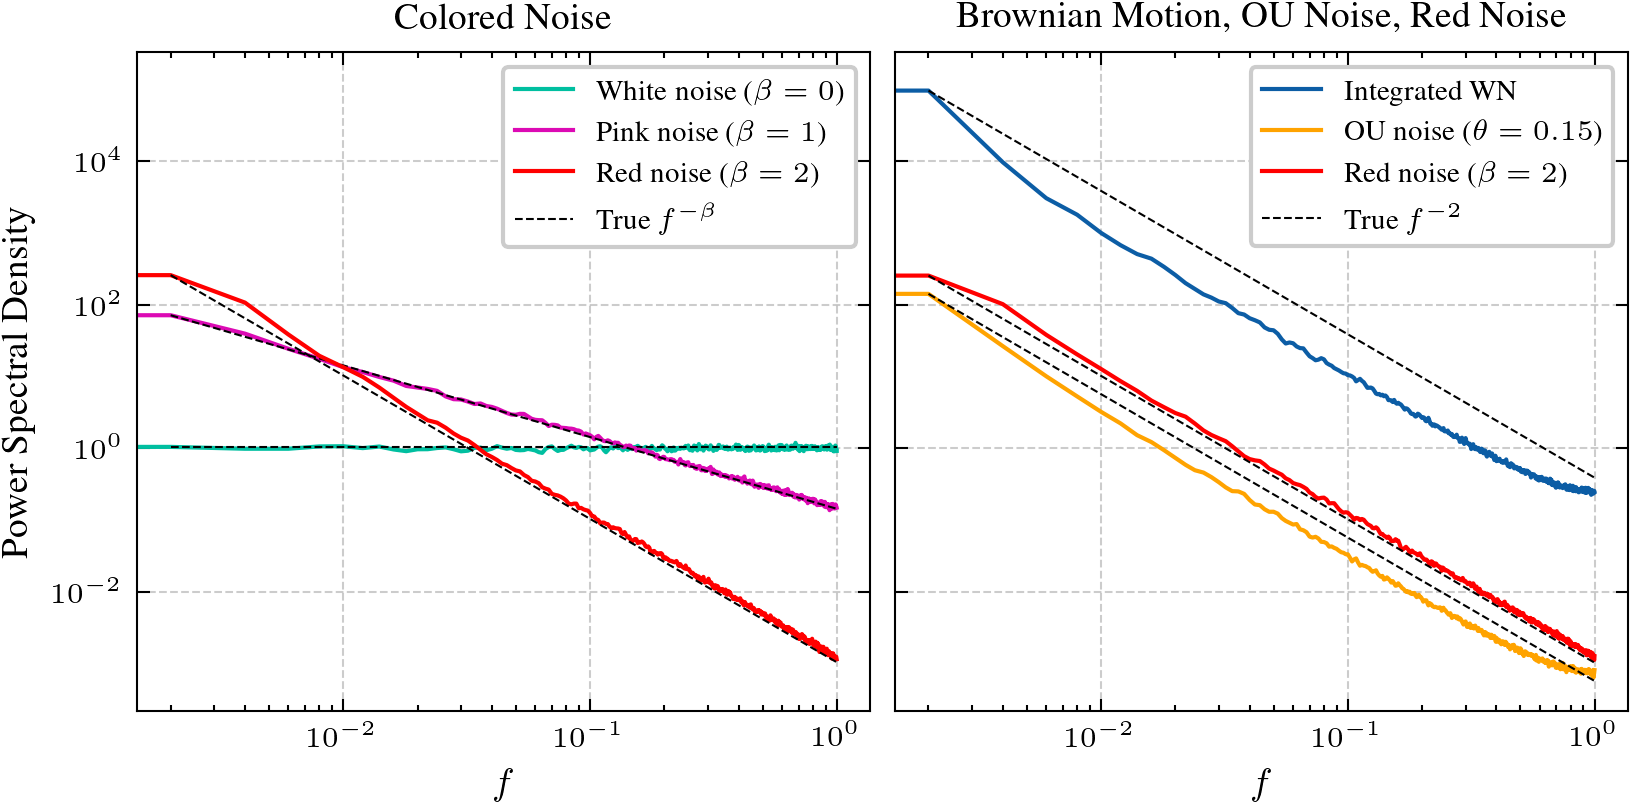

In [23]:
C = [0, 0.5, 1, 1.5, 2]

rng = np.random.default_rng(42)

fig, ax = plt.subplots(1, 2, figsize=(W, W/2), sharex=True, sharey=True)
ax[0].set_ylabel('Power Spectral Density')
ax[0].set_xlabel('$f$')
ax[0].set_title('Colored Noise')

ax[1].set_xlabel('$f$')
ax[1].set_title('Brownian Motion, OU Noise, Red Noise')

# Colored noise
s, f = mlab.psd(cn.powerlaw_psd_gaussian(0, (500, 1000), rng=rng).ravel(), NFFT=1000, Fs=2)
ax[0].loglog(f[:-1],s[:-1], color=colors['WN'], label=r'White noise ($\beta=0$)')
ps_ = 1 / f[1:]**0
ax[0].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5)

s, f = mlab.psd(cn.powerlaw_psd_gaussian(1, (500, 1000), rng=rng).ravel(), NFFT=1000, Fs=2)
ax[0].loglog(f[:-1],s[:-1], color=colors['Pink'], label=r'Pink noise ($\beta=1$)')
ps_ = 1 / f[1:]**1
ax[0].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5)

s, f = mlab.psd(cn.powerlaw_psd_gaussian(2, (500, 1000), rng=rng).ravel(), NFFT=1000, Fs=2)
ax[0].loglog(f[:-1],s[:-1], color='red', label=r'Red noise ($\beta=2$)')
ps_ = 1 / f[1:]**2
ax[0].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5, 
            label=(r'True $f^{-\beta}$'))


ax[0].legend()

s, f = mlab.psd((cn.powerlaw_psd_gaussian(exponent=0, size=(500, 1000))).cumsum(1).ravel(), NFFT=1000, Fs=2)
ax[1].loglog(f[:-1],s[:-1], color='C0', label=r'Integrated WN')
ps_ = 1 / f[1:]**2
ax[1].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5)


s, f = mlab.psd(get_ou(500, 1000, 0.15, rng=rng).ravel(), NFFT=1000, Fs=2)
ax[1].loglog(f[:-1],s[:-1], color=colors['OU'], label=r'OU noise ($\theta = 0.15$)')
ps_ = 1 / f[1:]**2
ax[1].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5)

s, f = mlab.psd(cn.powerlaw_psd_gaussian(2, (500, 1000), rng=rng).ravel(), NFFT=1000, Fs=2)
ax[1].loglog(f[:-1],s[:-1], color='red', label=r'Red noise ($\beta=2$)')
ps_ = 1 / f[1:]**2
ax[1].plot(f[1:], ps_ * s[1] / ps_[0], 'k--', lw=0.5, 
            label=(r'True $f^{-2}$'))

ax[1].legend()

fig.savefig('doc/paper/fig/psd.pdf')
plt.show()

/var/folders/nh/02c5_5bn2k97xpljx3m07hrm0000gn/T/ipykernel_8898/1604337662.py:32: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im[3], pad=0, extend='max')


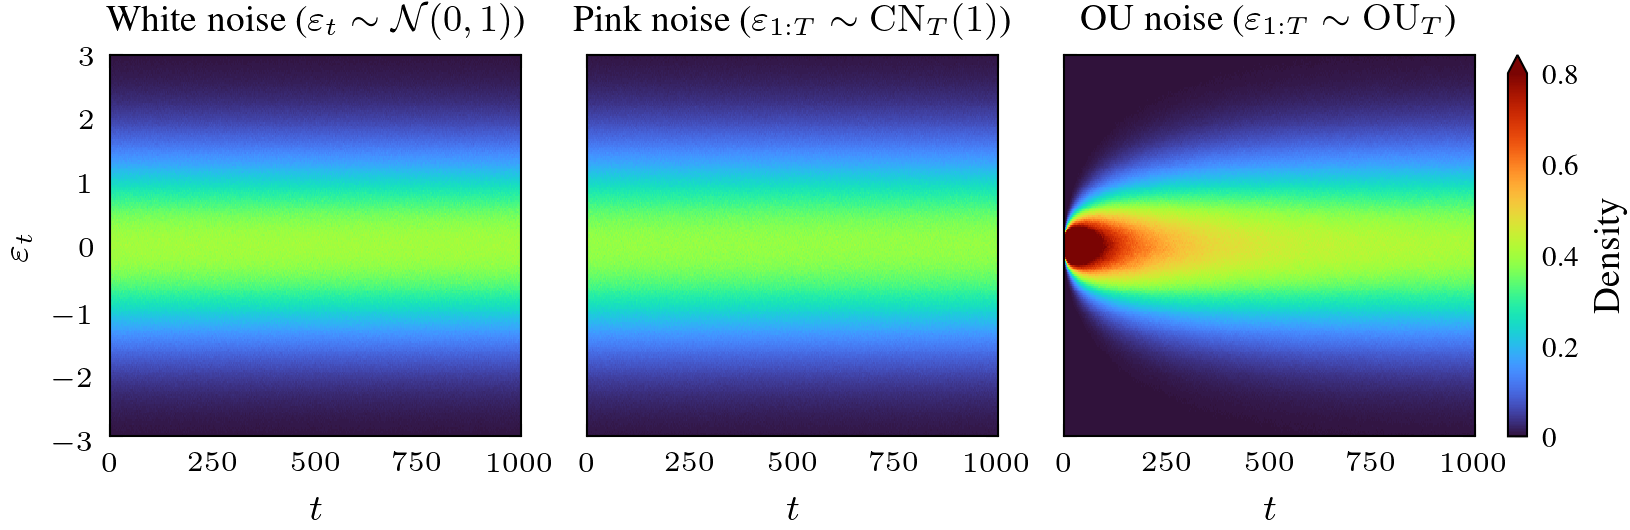

In [25]:
# Colored noise marginally Gaussian? (histogram calculation takes a while)
rng = np.random.default_rng(42)
N = 300_000
T = 1000
x = cn.powerlaw_psd_gaussian(1, (N, T), rng=rng)
y = rng.normal(size=(N, T))
z = get_ou(N, T, rng=rng)

fig, ax = plt.subplots(1, 3, figsize=(W, W/3), sharex=True, sharey=True)
ax[0].set_title(r'White noise ($\varepsilon_t \sim \mathcal N(0, 1)$)')
ax[1].set_title(r'Pink noise ($\varepsilon_{1:T} \sim \operatorname{CN}_T(1)$)')
ax[2].set_title(r'OU noise ($\varepsilon_{1:T} \sim \operatorname{OU}_T$)')
ax[0].set_ylabel(r'$\varepsilon_t$')

ax[0].set_xlabel('$t$')
ax[1].set_xlabel('$t$')
ax[2].set_xlabel('$t$')

p = 0.8    # = maximum density
left = -3
right = 3
bins = 200
max_prop = p * (right - left) / bins

cmap = 'turbo'
ax[0].hist2d(np.repeat(np.arange(T), N), y.T.flatten(), bins=(T, bins), range=[[0, T], [left, right]], rasterized=True,
             vmin=0, vmax=N*max_prop, cmap=cmap)
im = ax[1].hist2d(np.repeat(np.arange(T), N), x.T.flatten(), bins=(T, bins), range=[[0, T], [left, right]],
                  rasterized=True,vmin=0, vmax=N*max_prop, cmap=cmap)
ax[2].hist2d(np.repeat(np.arange(T), N), z.T.flatten(), bins=(T, bins), range=[[0, T], [left, right]],
                  rasterized=True,vmin=0, vmax=N*max_prop, cmap=cmap)
cbar = fig.colorbar(im[3], pad=0, extend='max')
cbar.set_ticks([0, N*max_prop//4, N*max_prop//2, 3*N*max_prop//4, N*max_prop])
# cbar.set_ticklabels(['0', f'{bins*max_prop}'])
# cbar.set_ticklabels([0, 0.1, 0.2, 0.3, 0.4])
cbar.set_ticklabels([0, 0.2, 0.4, 0.6, 0.8])
cbar.set_label('Density')

fig.savefig('doc/paper/fig/stationary.pdf')

In [108]:
rng = np.random.default_rng(42)
thetas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]    # dt=0.01
sf = []
for theta in thetas:
    s, f = mlab.psd(get_ou(500, 100000, theta, rng=rng).ravel(), NFFT=100000, Fs=2)
    sf.append((s, f))

In [122]:
H = np.load('dat/H.npy')
z = np.load('dat/energy.npy')
me = np.load('dat/cos.npy')
H_ou = np.load('dat/H-ou.npy')
z_ou = np.load('dat/energy-ou.npy')

In [128]:
C = 200
F = 200
cs = np.logspace(np.log10(25), np.log10(1000), C)
E = np.logspace(np.log10(1/4000), np.log10(1/2), F)

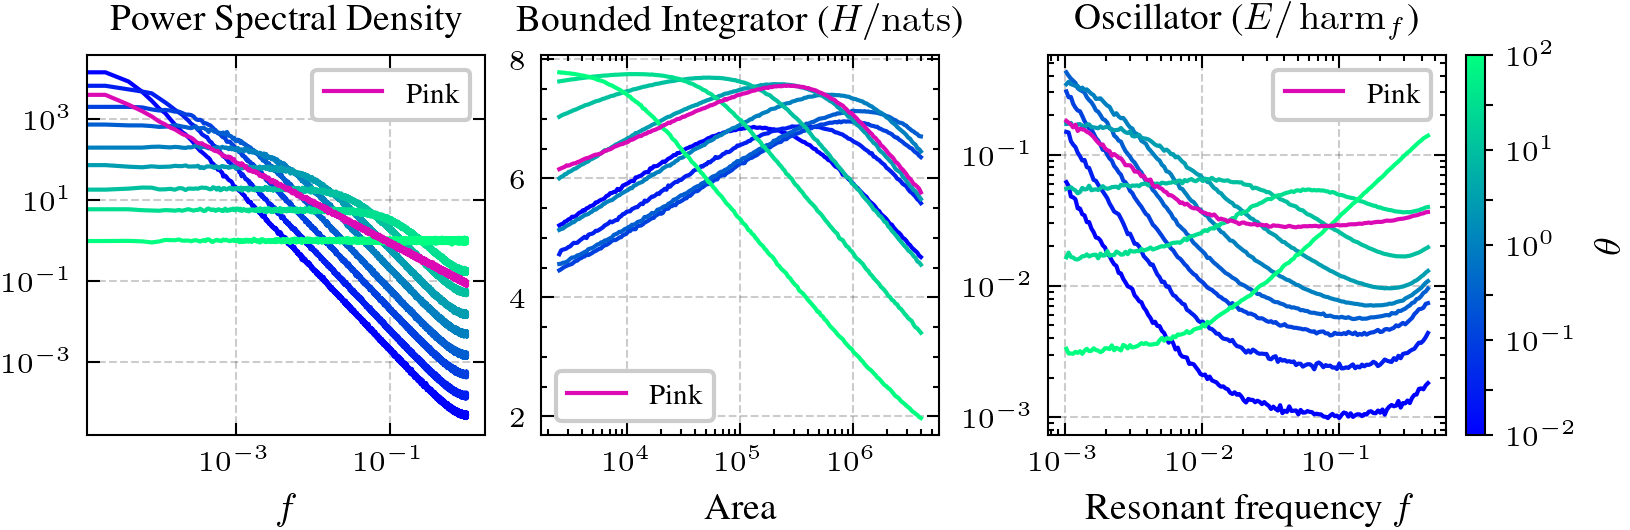

In [142]:
thetas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]    # dt=0.01

rng = np.random.default_rng(42)

fig, ax = plt.subplots(1, 3, figsize=(W, W/3))

norm_ = LogNorm(vmin=min(thetas), vmax=max(thetas))

ax[0].set_title('Power Spectral Density')
ax[0].set_xlabel('$f$')

for i, theta in enumerate(thetas):
    s, f = sf[i]
    ax[0].loglog(f[:-1], s[:-1], color=cm.winter(norm_(theta)))

s, f = mlab.psd(cn.powerlaw_psd_gaussian(1, (500, 100000), rng=rng).ravel(), NFFT=100000, Fs=2)
ax[0].loglog(f[:-1], s[:-1], color=colors['Pink'], label="Pink")
ax[0].legend()

ax[1].set_title(r"Bounded Integrator ($H / \mathrm{nats}$)")
ax[1].set_xlabel(r"Area")
for i, theta in enumerate(thetas):
    ax[1].semilogx((2*cs)**2, H_ou[i], color=cm.winter(norm_(theta)))

ax[1].semilogx((2*cs)**2, H[1], color=colors['Pink'], label='Pink')
ax[1].legend()



ax[2].set_title(r"Oscillator ($E / \operatorname{harm}_f$)")
ax[2].set_xlabel('Resonant frequency $f$')

for i, theta in enumerate(thetas):
    ax[2].loglog(E[E >= 1e-3][:-3], (z_ou[i] / me.mean(-1))[E >= 1e-3][:-3], color=cm.winter(norm_(theta)))

ax[2].loglog(E[E >= 1e-3][:-3], (z[1].mean((1, 2)) / me.mean(-1))[E >= 1e-3][:-3], label=f'Pink', color=colors["Pink"])
ax[2].legend()


cbar = fig.colorbar(cm.ScalarMappable(norm=norm_, cmap=cm.winter), ax=ax[-1]) #, pad=0)
cbar.set_ticks(thetas)
cbar.ax.tick_params(length=2, width=0.5, direction='out')
cbar.set_label(r'$\theta$')

fig.savefig('doc/paper/fig/ou-dynamics.pdf')

In [180]:
# Bounded integrator (OU and pink noise)
print((H_ou / H_ou.max(0)).min(1).max())
print(thetas[(H_ou / H_ou.max(0)).min(1).argmax()])
print((H[1] / H_ou.max(0)).min())

0.7711091650332392
3
0.7908814798449835


In [184]:
# Oscillator generality
op_ou = z_ou / me.mean(1)
op_pink = z[1].mean((1, 2)) / me.mean(1)

print((op_ou  / op_ou.max(0)).min(1).max())
print(thetas[(op_ou  / op_ou.max(0)).min(1).argmax()])
print((op_pink / op_ou.max(0)).min())

0.091096091465895
3
0.21778907826596852


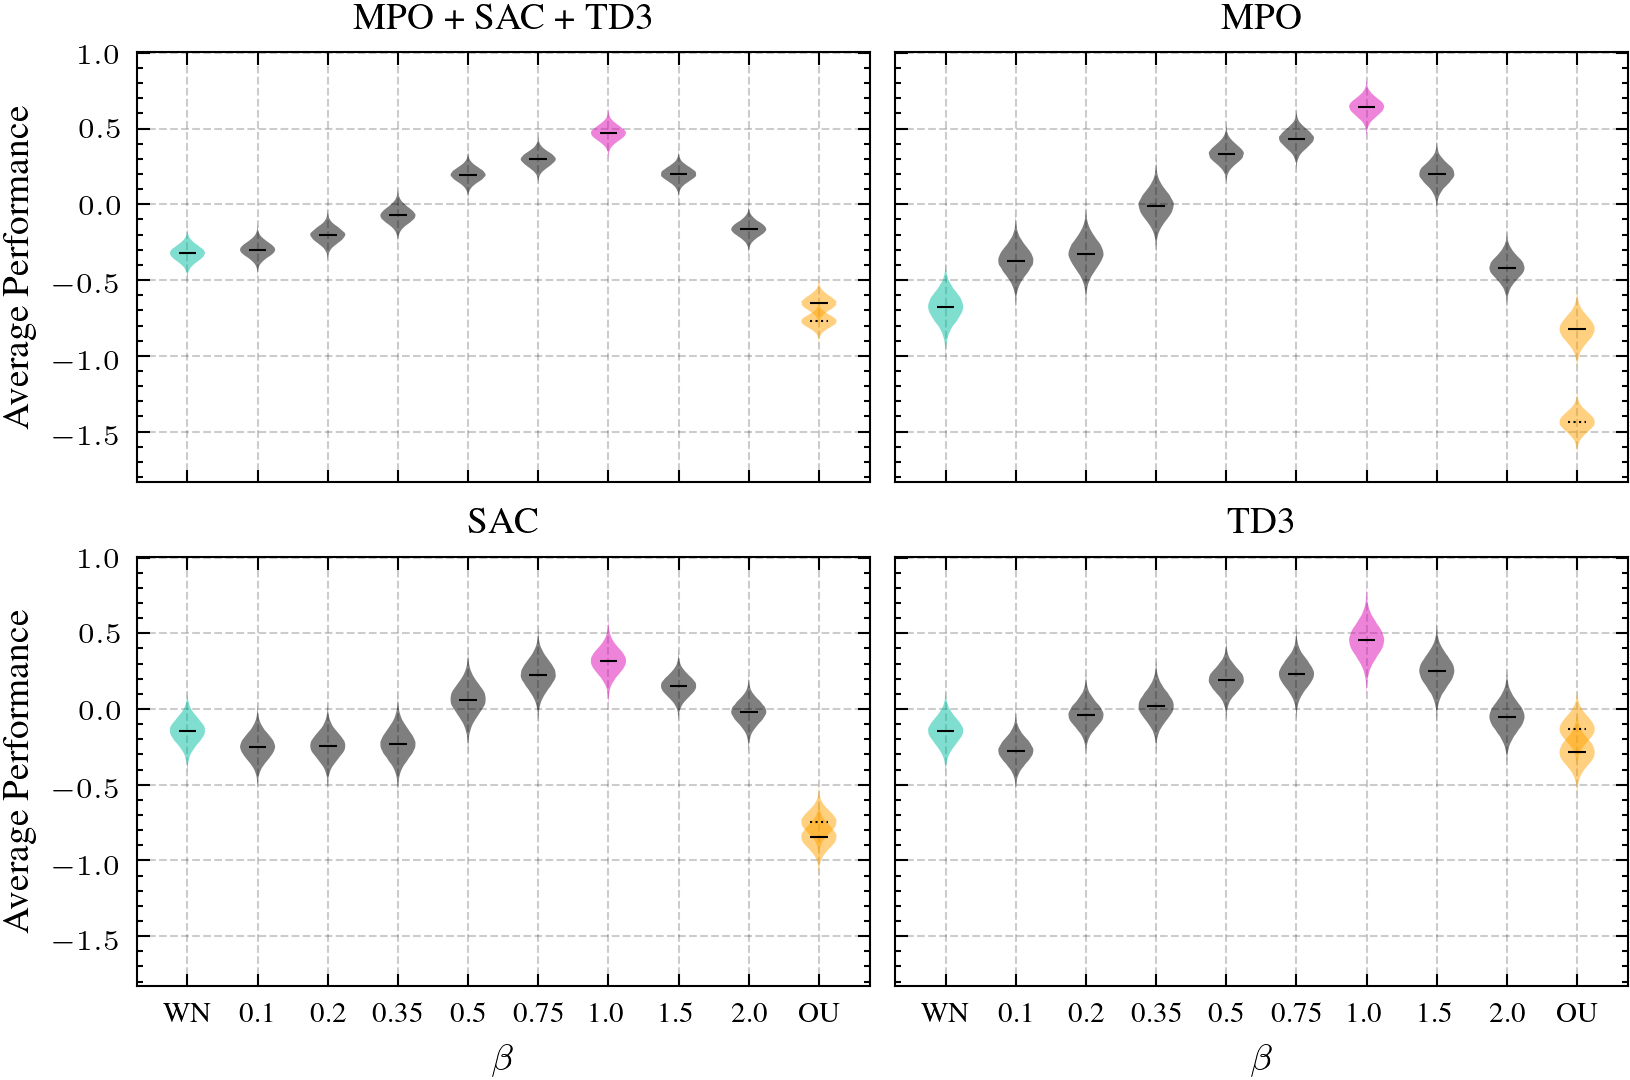

In [18]:
fig, a = plt.subplots(2, 2, figsize=(W, W/1.5), sharex=True, sharey=True)
a = a.ravel()

a[0].set_ylabel("Average Performance")
a[2].set_ylabel("Average Performance")
a[2].set_xlabel(r"$\beta$")
a[3].set_xlabel(r"$\beta$")
a[0].set_title("MPO + SAC + TD3")
a[1].set_title("MPO")
a[2].set_title("SAC")
a[3].set_title("TD3")

for ax, algorithm in zip(a, ["", "mpo", "sac", "td3"]):
    filtered_data = data if algorithm == "" else data.query("agent == @algorithm")
    filtered_data = filtered_data.query("seed < 10")
    consdata = ou_gaussian_as_beta(filtered_data, set_noise_constant=False)
    if algorithm == "td3":
        consdata = consdata.groupby(["env", "agent", "seed", "beta", "noise"]).mean().reset_index()  # average of sigmas
    if algorithm == "":
        others = consdata.query("agent != 'td3'")
        td3data = consdata.query("agent == 'td3'")
        td3data = td3data.groupby(["env", "agent", "seed", "beta", "noise"]).mean().reset_index()  # average of sigmas
        consdata = pd.concat([others, td3data])
    
    normdata = normalize_group(consdata, ['env', 'agent'], ignore_column=['beta', 'seed'])#, 'sigma'])

    betas = data.beta.dropna().unique()[1:]

    # Bootstrapping
    N = 100_000
    S = 10
    xs = []
    xs.append(bootstrap_average(normdata.query("noise == 'wn'"), N=N*S).reshape(N, S).mean(axis=1))
    for beta in betas:
        xs.append(bootstrap_average(normdata.query(f"noise == 'constant' and beta == {beta}"), N=N*S).reshape(N, S).mean(axis=1))
    xs.append(bootstrap_average(normdata.query("noise == 'ou'"), N=N*S).reshape(N, S).mean(axis=1))

    violins = ax.violinplot(xs, showmeans=True, showextrema=False)

    violins['cmeans'].set_edgecolor('k')
    violins['cmeans'].set_linewidth(0.5)

    for v in violins['bodies']:
        v.set_facecolor('k')
        v.set_alpha(0.5)

    violins['bodies'][0].set_facecolor(colors['WN'])
    violins['bodies'][6].set_facecolor(colors['Pink'])
    violins['bodies'][-1].set_facecolor(colors['OU'])

    filtered_data = oudata if algorithm == "" else oudata.query("agent == @algorithm")
    filtered_data = filtered_data.query("seed < 10")
    consdata = ou_gaussian_as_beta(filtered_data, set_noise_constant=False)
    if algorithm == "td3":
        consdata = consdata.groupby(["env", "agent", "seed", "beta", "noise"]).mean().reset_index()  # average of sigmas
    if algorithm == "":
        others = consdata.query("agent != 'td3'")
        td3data = consdata.query("agent == 'td3'")
        td3data = td3data.groupby(["env", "agent", "seed", "beta", "noise"]).mean().reset_index()  # average of sigmas
        consdata = pd.concat([others, td3data])
    
    normdata = normalize_group(consdata, ['env', 'agent'], ignore_column=['beta', 'seed'])#, 'sigma'])

    violins = ax.violinplot([
        bootstrap_average(normdata.query("noise == 'ou'"), N=N*S).reshape(N, S).mean(axis=1)], [10], showmeans=True, showextrema=False)

    violins['cmeans'].set_edgecolor('k')
    violins['cmeans'].set_linestyle(':')
    violins['cmeans'].set_linewidth(0.5)

    for v in violins['bodies']:
        v.set_facecolor('k')
        v.set_alpha(0.5)

    violins['bodies'][-1].set_facecolor(colors['OU'])

    ax.set_xticks(range(1, len(betas)+3))
    ax.set_xticklabels(['WN'] + list(betas) + ['OU'])
    ax.xaxis.set_minor_locator(plt.NullLocator())

fig.savefig('doc/paper/fig/allbetaall.pdf')

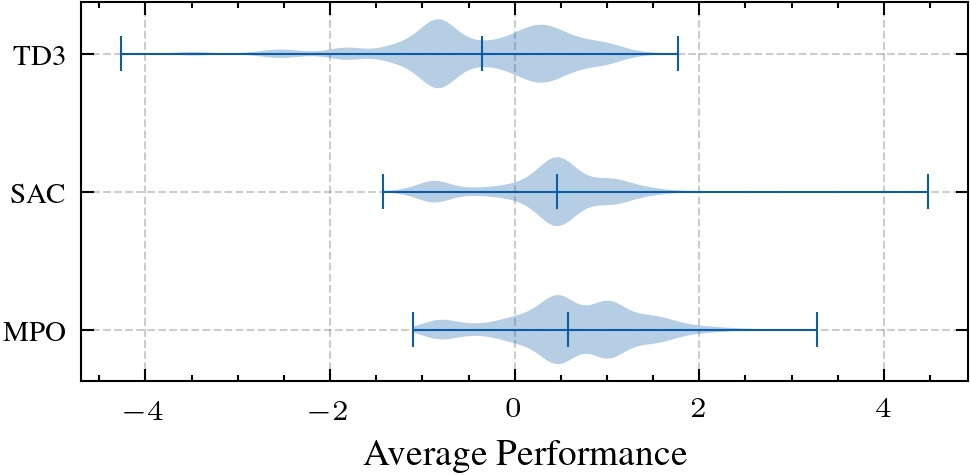

In [28]:
fig, ax = plt.subplots(figsize=(0.6*W, 0.6*W/2))

data_ = data.query("noise in ['constant', 'wn']")
data_ = normalize_group(data_, ["env"]).groupby('agent')
ks = sorted(data_.groups.keys())
violins = ax.violinplot([data_.get_group(k)['perf'] for k in ks], vert=False, showmedians=True)

for x in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
    violins[x].set_linewidth(0.5)

ax.set_xlabel("Average Performance")
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.set_yticks([1, 2, 3], ["MPO", "SAC", "TD3"])

fig.savefig("doc/paper/fig/td3-bad.pdf")

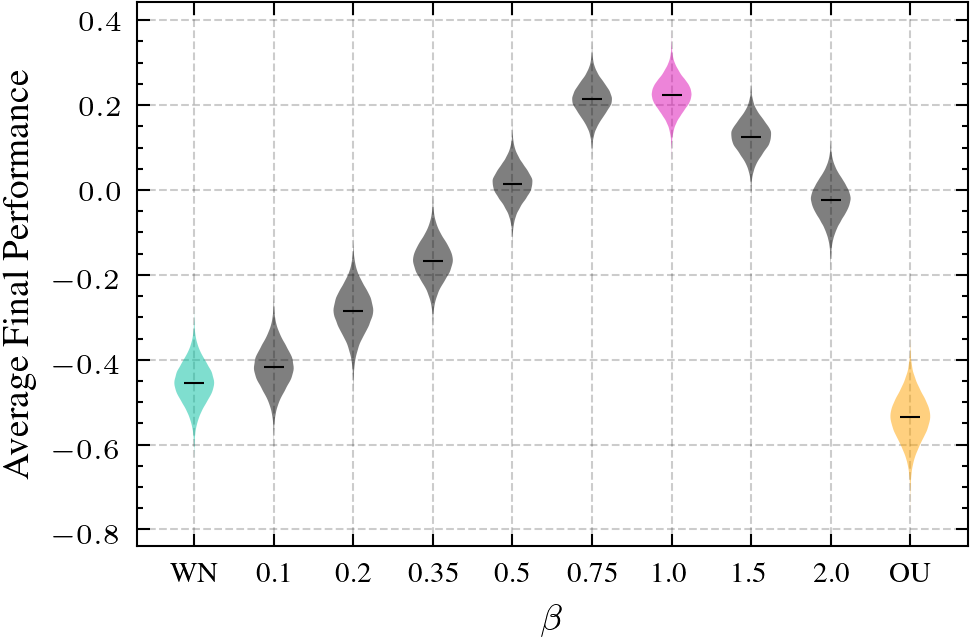

In [9]:
# final performance bootstrapping
data_final = pd.read_csv('dat/data_95_100.csv')

betas = data_final.beta.dropna().unique()[1:]

# Normalize data
consdata = data_final.query("agent != 'td3'")
normdata = normalize_group(consdata, ['env', 'agent'], ignore_column=['beta', 'seed', 'sigma'])

# Bootstrapping
N = 100_000
S = 20
xs = []
xs.append(bootstrap_average(normdata.query("noise == 'wn'"), N=N*20).reshape(N, 20).mean(axis=1))
for beta in betas:
    xs.append(bootstrap_average(normdata.query(f"noise == 'constant' and beta == {beta}"), N=N*20).reshape(N, 20).mean(axis=1))
xs.append(bootstrap_average(normdata.query("noise == 'ou'"), N=N*20).reshape(N, 20).mean(axis=1))

# fig, ax = plt.subplots(figsize=(W, W/2))
fig, ax = plt.subplots(figsize=(0.6*W, 0.6*W/1.5))
ax.set_ylabel("Average Final Performance")
ax.set_xlabel(r"$\beta$")
violins = ax.violinplot(xs, showmeans=True, showextrema=False) #, quantiles=[[0.025, 0.975]]*len(xs), showextrema=False) #, labels=['WN'] + list(betas) + ['OU'], showfliers=False)

violins['cmeans'].set_edgecolor('k')
violins['cmeans'].set_linewidth(0.5)

for v in violins['bodies']:
    v.set_facecolor('k')
    v.set_alpha(0.5)

violins['bodies'][0].set_facecolor(colors['WN'])
violins['bodies'][6].set_facecolor(colors['Pink'])
violins['bodies'][-1].set_facecolor(colors['OU'])

ax.set_xticks(range(1, len(betas)+3))
ax.set_xticklabels(['WN'] + list(betas) + ['OU'])
ax.xaxis.set_minor_locator(plt.NullLocator())

fig.savefig('doc/paper/fig/allbeta-final.pdf')
plt.show()

In [7]:
runs = [
    # Constant CN
    'benchmark-sac-const-2', 'benchmark-sac-const-fix', 'benchmark-sac-const-fix2',
    'benchmark-mpo-const', 'benchmark-mpo-const-fix', 'benchmark-mpo-const-fix2',
    'benchmark-td3-const-2',
    # WN
    'benchmark-td3-wn', 'benchmark-td3-wn-fix', 'benchmark-td3-wn-fix2',
    'benchmark-wn', 'benchmark-wn-fix', 'benchmark-wn-fix2',
    # OU
    'ou', 'ou-fix', 'ou-td3', 'ou-td3-fix',
    # Bandit
    'bandit', 'bandit-fix', 'bandit-td3', 'bandit-td3-fix',
    # Random
    'random', 'random-fix', 'random-td3', 'random-td3-fix', 
    # Schedule
    'schedule', 'schedule-fix', 'schedule-td3', 'schedule-td3-fix',
    'schedule-atanh', 'schedule-atanh-td3', 'schedule-atanh-fix',
    'schedule-atanh-fix2', 'schedule-atanh-td3-fix'
]
runs_ou = ['ou-sc']
envs = {
    ('pendulum', 'swingup'): "Pendulum",
    ('cartpole', 'balance_sparse'): "Cartpole (b.)",
    ('cartpole', 'swingup_sparse'): "Cartpole (s.)",
    ('ball_in_cup', 'catch'): "Ball-In-Cup",
    'MountainCarContinuous-v0': "MountainCar",
    ('hopper', 'hop'): "Hopper",
    ('walker', 'run'): "Walker",
    ('reacher', 'hard'): "Reacher",
    ('cheetah', 'run'): "Cheetah",
    'door-v0': "Door"
}
betas = [0, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2]
sigmas = [0.05, 0.1, 0.3, 0.5, 1]
bandit_methods = ['ind', 'list', 'cont']
bandit_scores = ['return', 'info']
random_methods = ['list', 'list2', 'cont', 'cont2']
schedule_methods = ['linear', 'atanh']

21/20 runs found: {'env': ('cartpole', 'balance_sparse'), 'agent': 'sac', 'noise': 'wn'}
21/20 runs found: {'env': ('cartpole', 'swingup_sparse'), 'agent': 'sac', 'noise': 'wn'}
21/20 runs found: {'env': ('ball_in_cup', 'catch'), 'agent': 'sac', 'noise': 'wn'}


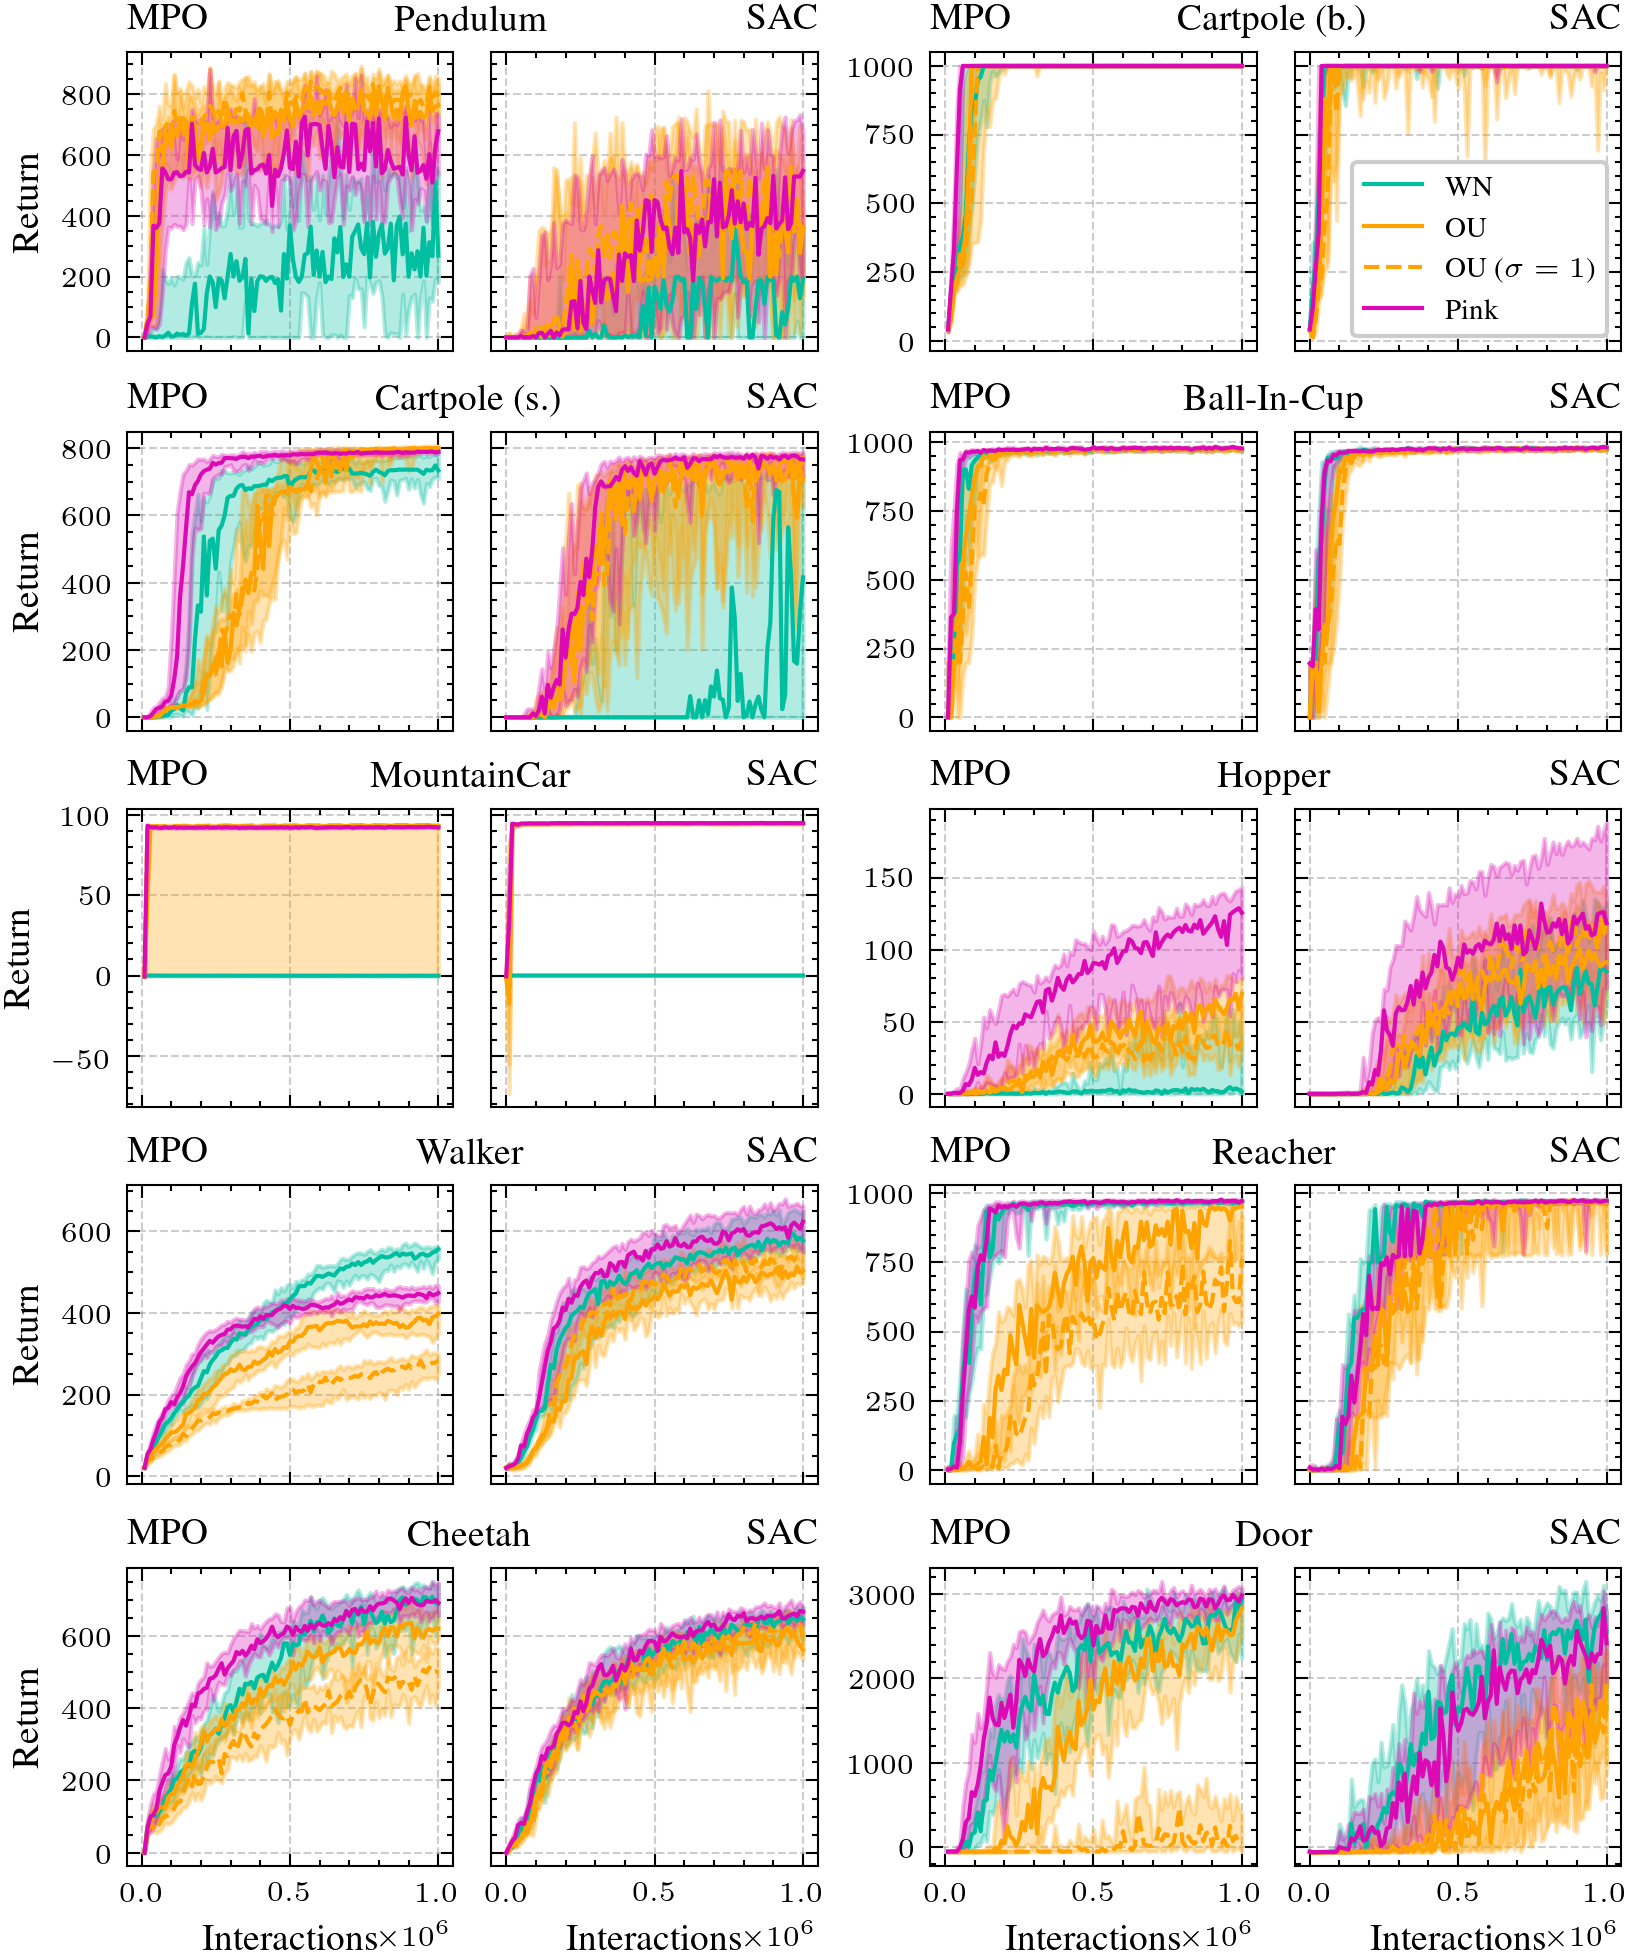

In [10]:
fig, ax = plt.subplots(5, 4, sharex=True, figsize=(W, 1.2*W)) #, gridspec_kw={'hspace': 0.3, 'top': 0.3})
a = ax.ravel()

for i, (env, name) in enumerate(envs.items()):
    # plot(ax[2*i], runs, env, 'sac', 'bandit', 'info')

    w = a[2*i].get_window_extent().transformed(fig.dpi_scale_trans.inverted()).width
    # ax[2*i].set_title(rf'.\hspace{{{w}in}}{env}''\nSAC')
    # ax[2*i].set_title(f'{env}', y=1.0, pad=0)
    fig.text(1.05, 1.05, name,
        horizontalalignment='center', verticalalignment='bottom', transform=a[2*i].transAxes)

    plot(a[2*i], runs, colors['WN'], n_runs=20, label=('WN' if i == 0 else None), env=env, agent='mpo', noise='wn')
    plot(a[2*i], runs_ou, colors['OU'], n_runs=20, label=(r'OU' if i == 0 else None), env=env, agent='mpo', noise='ou')
    plot(a[2*i], runs, colors['OU'], fmt='--', n_runs=20, label=(r'OU' if i == 0 else None), env=env, agent='mpo', noise='ou')
    plot(a[2*i], runs, colors['Pink'], n_runs=20, label=(r'$\beta = 1$' if i == 0 else None), env=env, agent='mpo', noise='const', beta=1)

    plot(a[2*i+1], runs, colors['WN'], n_runs=20, label=('WN' if i == 0 else None), env=env, agent='sac', noise='wn')
    plot(a[2*i+1], runs_ou, colors['OU'], n_runs=20, label=(r'OU' if i == 0 else None), env=env, agent='sac', noise='ou')
    plot(a[2*i+1], runs, colors['OU'], fmt='--', n_runs=20, label=(r'OU' if i == 0 else None), env=env, agent='sac', noise='ou')
    plot(a[2*i+1], runs, colors['Pink'], n_runs=20, label=(r'$\beta = 1$' if i == 0 else None), env=env, agent='sac', noise='constant', beta=1)

    a[2*i].set_title('MPO', loc='left')
    a[2*i + 1].set_title('SAC', loc='right')
    a[2*i + 1].sharey(a[2*i])
    a[2*i + 1].tick_params(labelleft=False)

ax[0, 0].set_ylabel('Return')
ax[1, 0].set_ylabel('Return')
ax[2, 0].set_ylabel('Return')
ax[3, 0].set_ylabel('Return')
ax[4, 0].set_ylabel('Return')
ax[-1, 0].set_xlabel('Interactions')
ax[-1, 1].set_xlabel('Interactions')
ax[-1, 2].set_xlabel('Interactions')
ax[-1, 3].set_xlabel('Interactions')
ax[0, 3].legend(handles=[Line2D([], [], c=colors['WN'], label=r'WN'),
                         Line2D([], [], c=colors['OU'], label=r'OU'),
                         Line2D([], [], c=colors['OU'], ls='--', label=r'OU ($\sigma=1$)'),
                         Line2D([], [], c=colors['Pink'], label=r'Pink')], loc='lower right')
# ax[0, 3].legend(handles=[Line2D([], [], c='C2', label=r'GP $S_\mathrm{info}$'),
#                          Line2D([], [], c='C3', label=r'GP $S_\mathrm{ret}$')], åloc='lower right')

fig.savefig('doc/paper/fig/learning-curves.pdf')

In [25]:
# how much performance is lost on pendulum and reacher when using pink noise instead of WN/OU noise?
# compute percentage for each seed/agent, average over both.
np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "constant" and beta == 1').perf.values) / np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "ou"').perf.values)

0.8253555970708798

In [37]:
# Pendulum: PN vs. RN
np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "constant" and beta == 1').perf.values) / np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "constant" and beta == 2').perf.values)

0.8262674671045622

In [38]:
# Pendulum: WN vs. RN
np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "wn"').perf.values) / np.sum(data.query('env == "(\'pendulum\', \'swingup\')" and agent != "td3" and noise == "constant" and beta == 2').perf.values)

0.3935160781365611

In [41]:
# Reacher: PN vs. WN
np.sum(data.query('env == "(\'reacher\', \'hard\')" and agent != "td3" and noise == "constant" and beta == 1').perf.values) / np.sum(data.query('env == "(\'reacher\', \'hard\')" and agent != "td3" and noise == "wn"').perf.values)

0.9852945693340497

In [44]:
# Reacher: OU vs. WN
np.sum(data.query('env == "(\'reacher\', \'hard\')" and agent != "td3" and noise == "ou"').perf.values) / np.sum(data.query('env == "(\'reacher\', \'hard\')" and agent != "td3" and noise == "wn"').perf.values)

0.7645659222228022

In [10]:
# TD3 is worst on all environments
data.query("noise in ['constant', 'wn']").groupby(['agent', 'env']).perf.mean().unstack().idxmin()

env
('ball_in_cup', 'catch')          td3
('cartpole', 'balance_sparse')    td3
('cartpole', 'swingup_sparse')    td3
('cheetah', 'run')                td3
('hopper', 'hop')                 td3
('pendulum', 'swingup')           td3
('reacher', 'hard')               td3
('walker', 'run')                 td3
MountainCarContinuous-v0          td3
door-v0                           td3
dtype: object

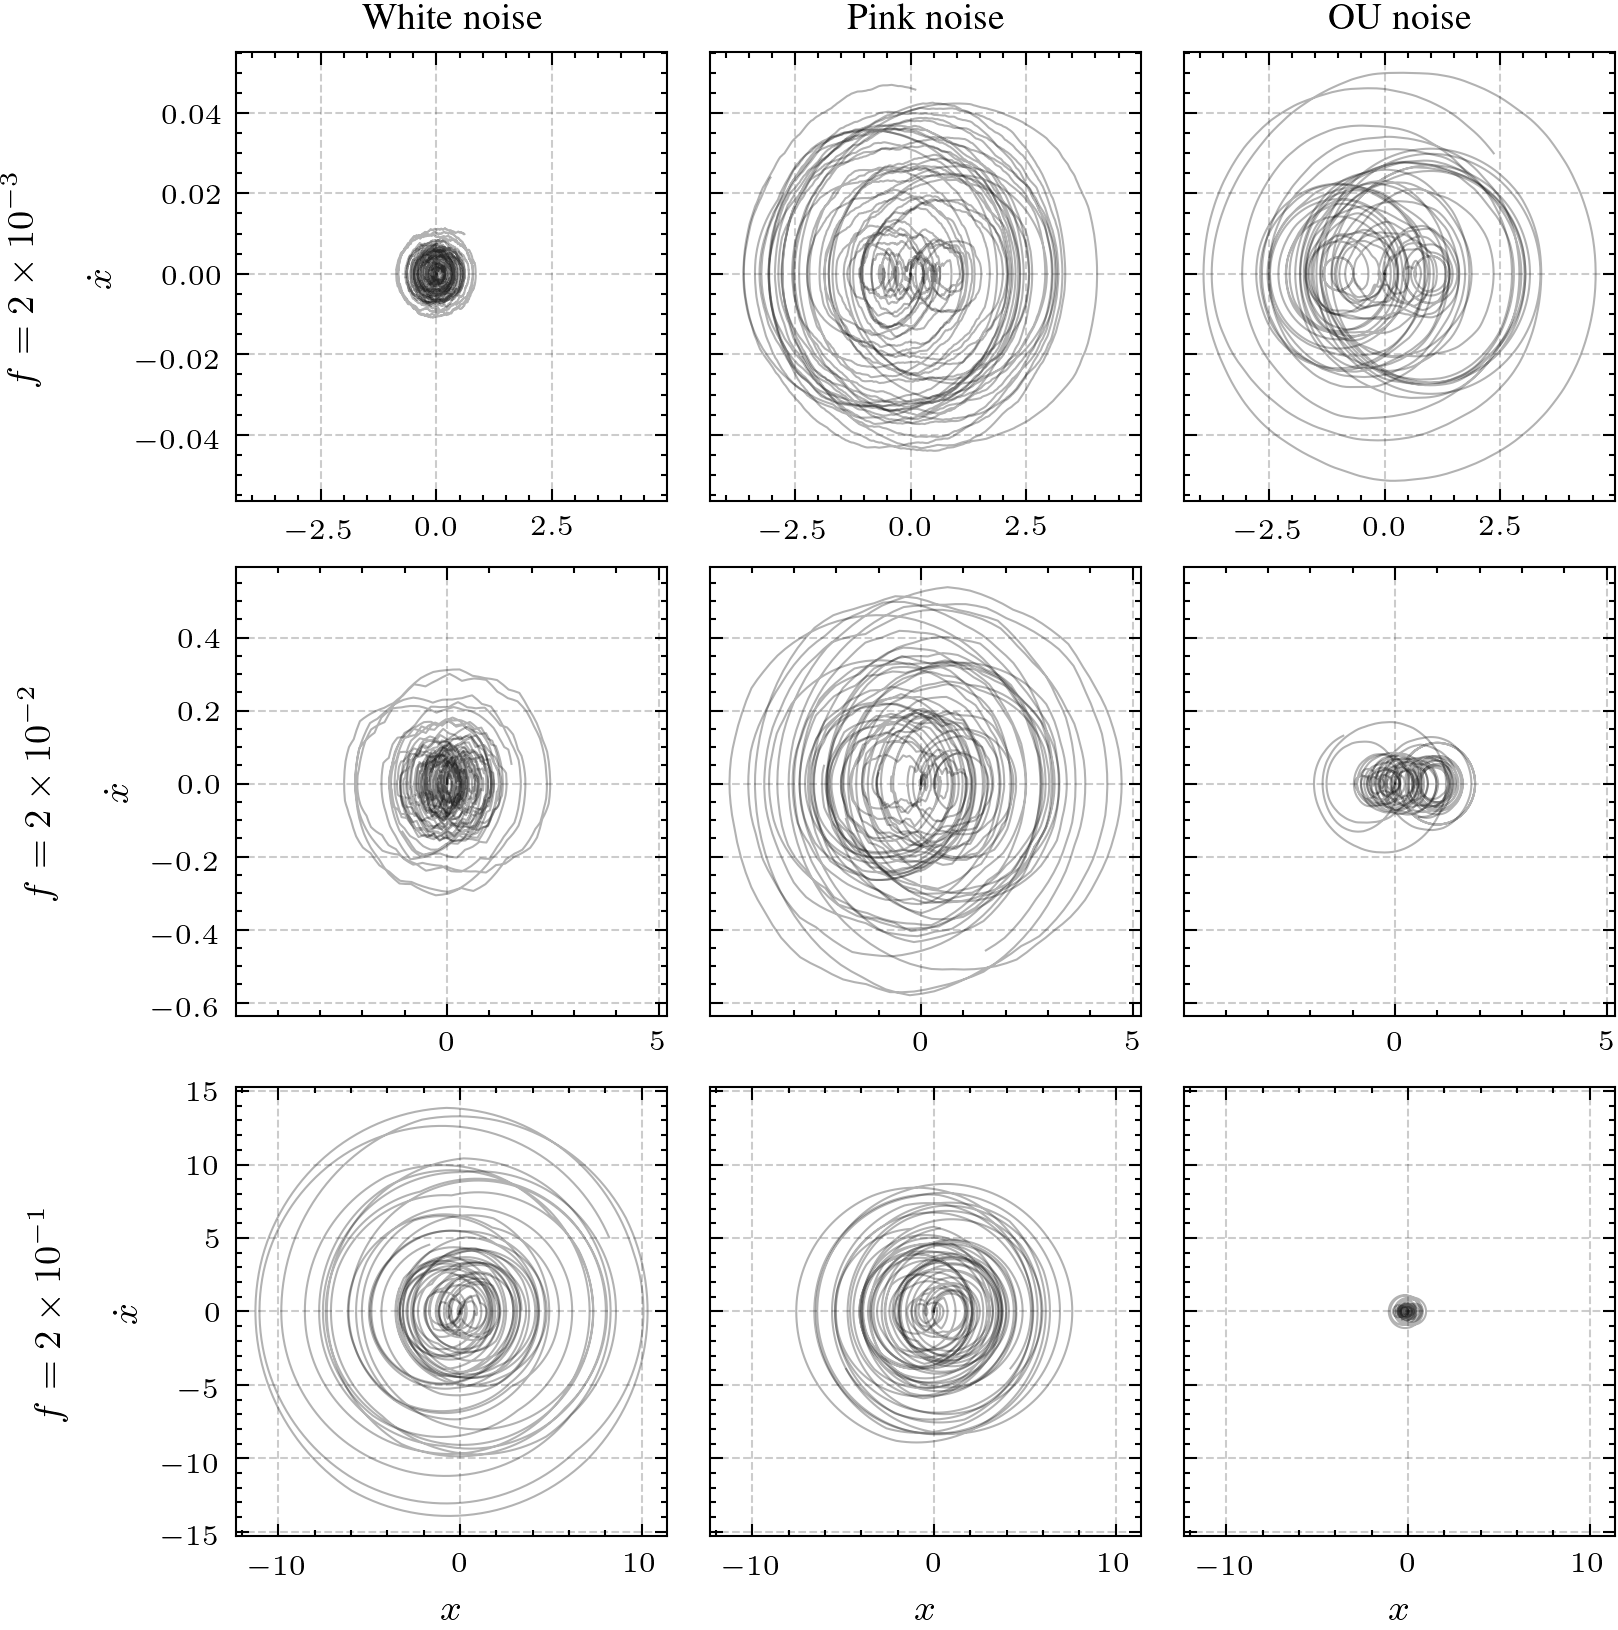

In [14]:
from oscillator import OscillatorEnv
N = 5
T = 1000

fig, ax = plt.subplots(3, 3, figsize=(W, W), sharex='row', sharey='row')
ax[0, 0].set_title('White noise')
ax[0, 1].set_title('Pink noise')
ax[0, 2].set_title('OU noise')
ax[0, 0].set_ylabel(r'$f = 2\times 10^{-3}$''\n\n'r'$\dot x$')
ax[1, 0].set_ylabel(r'$f = 2\times 10^{-2}$''\n\n'r'$\dot x$')
ax[2, 0].set_ylabel(r'$f = 2\times 10^{-1}$''\n\n'r'$\dot x$')
ax[-1, 0].set_xlabel(r'$x$')
ax[-1, 1].set_xlabel(r'$x$')
ax[-1, 2].set_xlabel(r'$x$')

for k, f in enumerate([2e-3, 2e-2, 2e-1]):
    rng = np.random.default_rng(42)
    osc = OscillatorEnv(frequency=f, target=None, res=100, initial_state=(0, 0), friction=0, max_periods=10, dt=1)
    T = osc._max_episode_steps
    for i, b in enumerate([0, 1, 'ou']):
        if b == 'ou':
            a = get_ou(N, T, rng=rng)
        else:
            a = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
        
        for j in range(N):
            x, y = osc.reset()
            xs = [x]
            ys = [y]
            for t in range(1, T):
                *_, info = osc.step([a[j, t]])
                for x, y in info['states']:
                    xs.append(x)
                    ys.append(y)

            ax[k, i].plot(xs, ys, 'k', alpha=0.3, lw=0.5)

fig.savefig('doc/paper/fig/osc-trajectories.pdf')
plt.show()

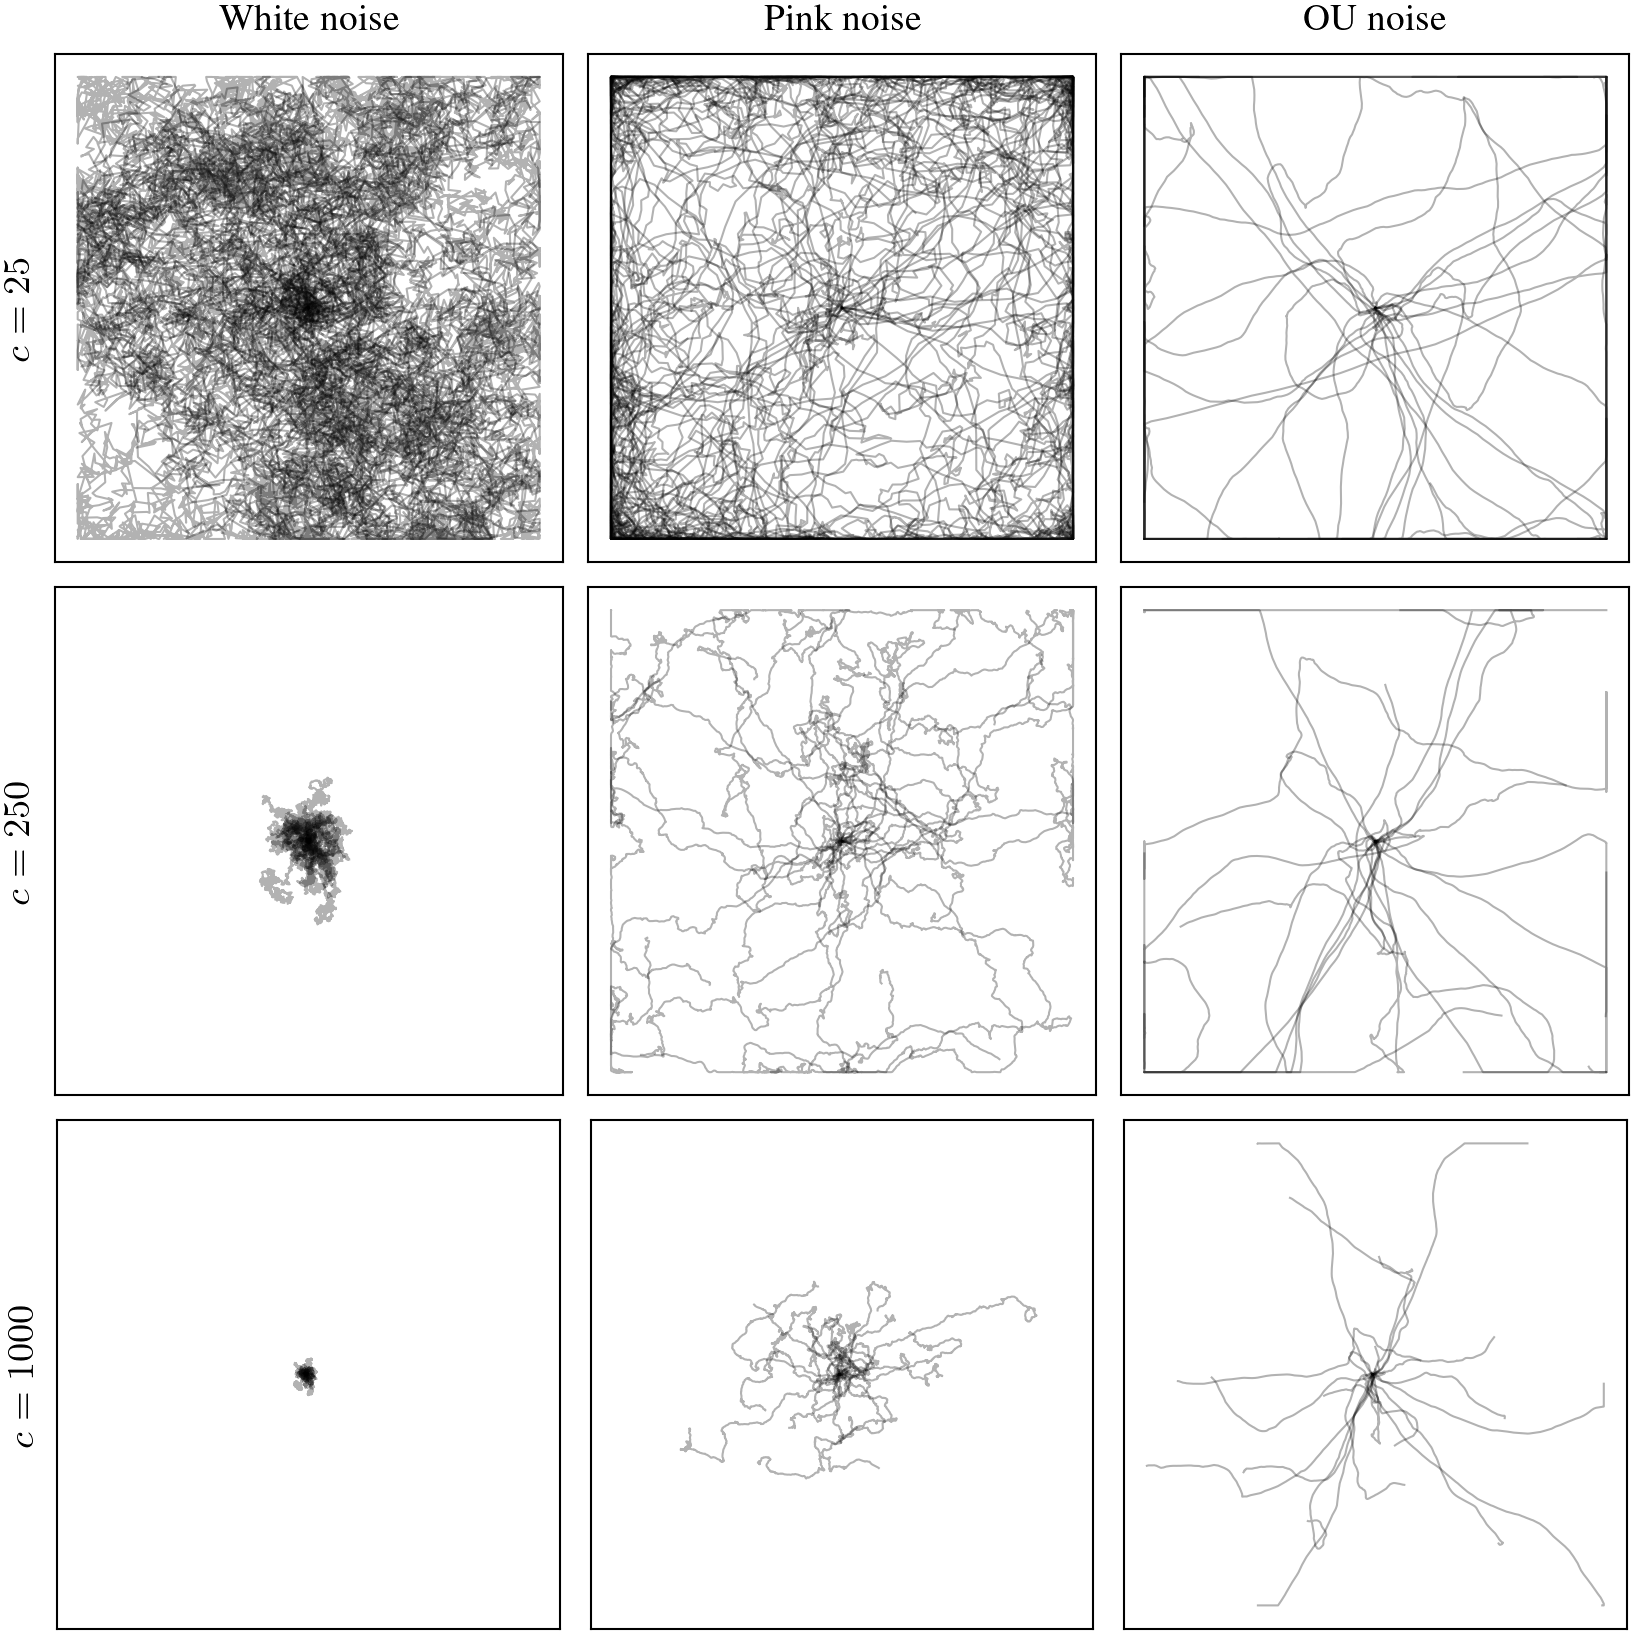

In [14]:
N = 20
T = 1000
c = 250

fig, ax = plt.subplots(3, 3, figsize=(W, W), sharex='row', sharey='row')
ax[0, 0].set_title('White noise')
ax[0, 1].set_title('Pink noise')
ax[0, 2].set_title('OU noise')
ax[0, 0].set_ylabel(r'$c = 25$')
ax[1, 0].set_ylabel(r'$c = 250$')
ax[2, 0].set_ylabel(r'$c = 1000$')

for k, c in zip([1, 0, 2], [250, 25, 1000]):
    rng = np.random.default_rng(6)
    for i, b in enumerate([0, 1, 'ou']):
        ax[k, i].grid(False)
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
        ax[k, i].set_aspect('equal')
        if b == 'ou':
            a_x = get_ou(N, T, rng=rng)
            a_y = get_ou(N, T, rng=rng)
        else:
            a_x = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)
            a_y = cn.powerlaw_psd_gaussian(b, (N, T), rng=rng)

        x = np.zeros_like(a_x)
        y = np.zeros_like(a_y)
        for t in range(1, T):
            x[:, t] = np.clip(x[:, t-1] + a_x[:, t], -c, c)
            y[:, t] = np.clip(y[:, t-1] + a_y[:, t], -c, c)
            
        for j in range(N):
            ax[k, i].plot(x[j], y[j], 'k', alpha=0.3, lw=0.5)

fig.savefig('doc/paper/fig/int-trajectories.pdf')

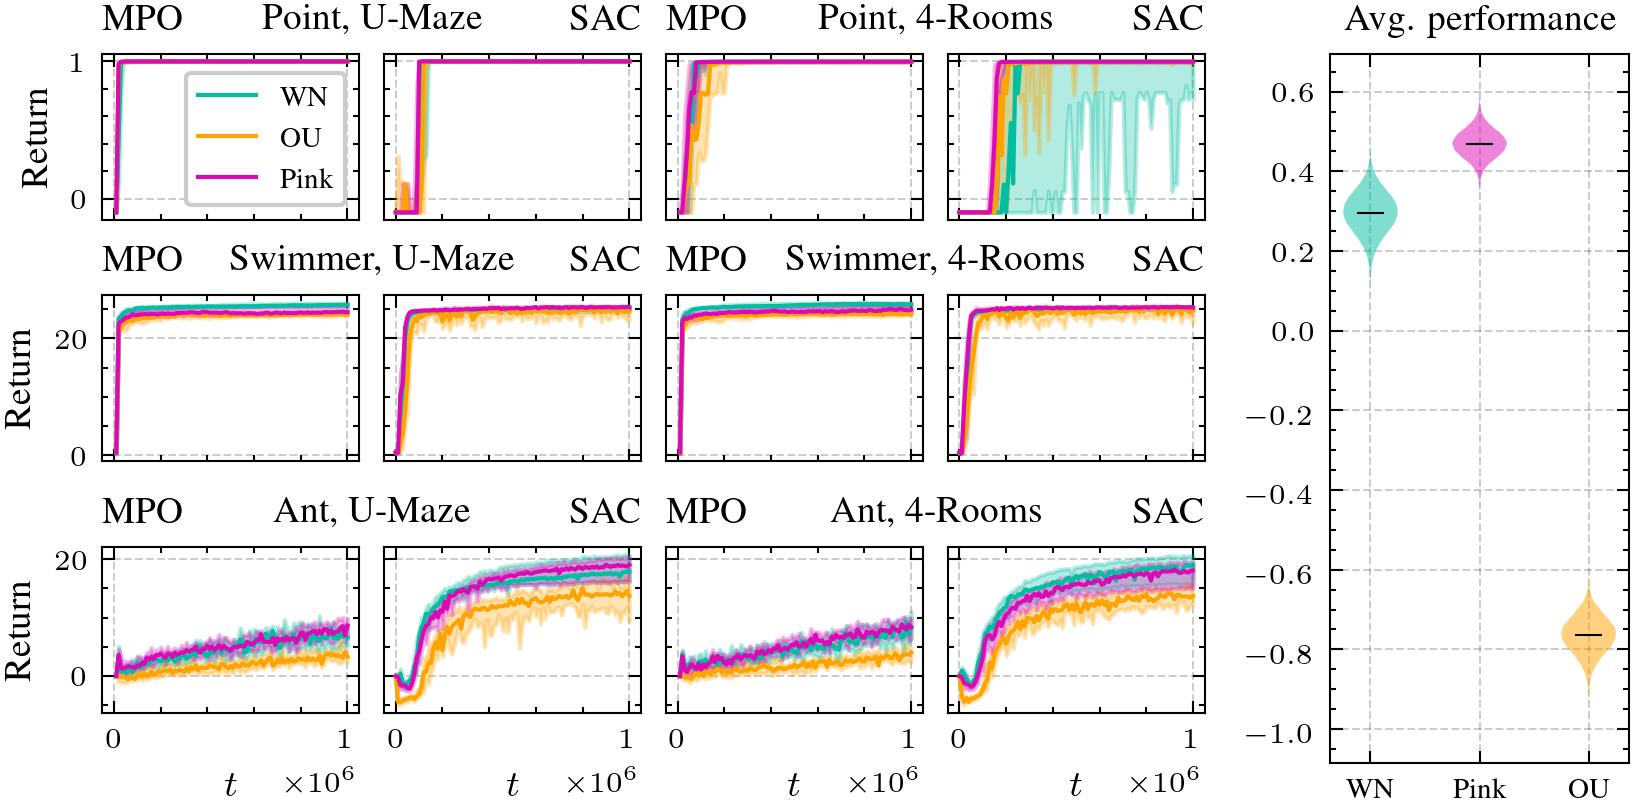

In [9]:
runs_mm = ['mujoco-maze', 'mujoco-maze-fix']
envs_mm = {
    'PointUMaze-v1': 'Point, U-Maze',
    'Point4Rooms-v1': 'Point, 4-Rooms',
    'SwimmerUMaze-v1': 'Swimmer, U-Maze',
    'Swimmer4Rooms-v1': 'Swimmer, 4-Rooms',
    'AntUMaze-v1': 'Ant, U-Maze',
    'Ant4Rooms-v1': 'Ant, 4-Rooms'
}

data_mm = []
for env in envs_mm:
    for agent in ['mpo', 'sac']:
        for noise in ['wn', 'ou', 'constant']:
            dat = get_box(runs_mm, n_runs=20, env=env, agent=agent, noise=noise)
            for seed in range(20):
                data_mm.append({'agent': agent, 'env': env, 'noise': noise, 'seed': seed, 'perf': dat[seed]})

data_mm = pd.DataFrame(data_mm)

fig = plt.figure(constrained_layout=True, figsize=(W, W/2))
figs = fig.subfigures(1, 2, width_ratios=[3, 1])
ax0 = figs[0].subplots(3, 4, sharex=True, sharey='row')
ax1 = figs[1].subplots()

a = ax0.ravel()

for i, (env, name) in enumerate(envs_mm.items()):
    w = a[2*i].get_window_extent().transformed(figs[0].dpi_scale_trans.inverted()).width
    figs[0].text(1.05, 1.1, name,
        horizontalalignment='center', verticalalignment='bottom', transform=a[2*i].transAxes)

    plot(a[2*i], runs_mm, colors['WN'], n_runs=20, env=env, agent='mpo', noise='wn')
    plot(a[2*i], runs_mm, colors['OU'], n_runs=20, env=env, agent='mpo', noise='ou')
    plot(a[2*i], runs_mm, colors['Pink'], n_runs=20, env=env, agent='mpo', noise='constant', beta=1)

    plot(a[2*i+1], runs_mm, colors['WN'], n_runs=20, env=env, agent='sac', noise='wn')
    plot(a[2*i+1], runs_mm, colors['OU'], n_runs=20, env=env, agent='sac', noise='ou')
    plot(a[2*i+1], runs_mm, colors['Pink'], n_runs=20, env=env, agent='sac', noise='constant', beta=1)

    a[2*i].set_title('MPO', loc='left')
    a[2*i + 1].set_title('SAC', loc='right')
    a[2*i + 1].tick_params(labelleft=False)

ax0[0, 0].set_ylabel('Return')
ax0[1, 0].set_ylabel('Return')
ax0[2, 0].set_ylabel('Return')
ax0[-1, 0].set_xlabel('$t$')
ax0[-1, 1].set_xlabel('$t$')
ax0[-1, 2].set_xlabel('$t$')
ax0[-1, 3].set_xlabel('$t$')
ax0[0, 0].legend(handles=[Line2D([], [], c=colors['WN'], label=r'WN'),
                         Line2D([], [], c=colors['OU'], label=r'OU'),
                         Line2D([], [], c=colors['Pink'], label=r'Pink')], loc='lower right')


# Normalize data
normdata_mm = normalize_group(data_mm, ['env', 'agent'], ignore_column=['seed'])

# Bootstrapping
N = 100_000
S = 20
xs = []
xs.append(bootstrap_average(normdata_mm.query("noise == 'wn'"), N=N*20).reshape(N, 20).mean(axis=1))
xs.append(bootstrap_average(normdata_mm.query(f"noise == 'constant'"), N=N*20).reshape(N, 20).mean(axis=1))
xs.append(bootstrap_average(normdata_mm.query("noise == 'ou'"), N=N*20).reshape(N, 20).mean(axis=1))

ax1.set_title("Avg. performance")
# ax.set_xlabel(r"$\beta$")
violins = ax1.violinplot(xs, showmeans=True, showextrema=False) #, quantiles=[[0.025, 0.975]]*len(xs), showextrema=False) #, labels=['WN'] + list(betas) + ['OU'], showfliers=False)

violins['cmeans'].set_edgecolor('k')
violins['cmeans'].set_linewidth(0.5)

for v in violins['bodies']:
    v.set_facecolor('k')
    v.set_alpha(0.5)

violins['bodies'][0].set_facecolor(colors['WN'])
violins['bodies'][1].set_facecolor(colors['Pink'])
violins['bodies'][2].set_facecolor(colors['OU'])

ax1.set_xticks(range(1, 4))
ax1.set_xticklabels(['WN', 'Pink', 'OU'])
ax1.xaxis.set_minor_locator(plt.NullLocator())

fig.savefig('doc/paper/fig/mujoco-maze.pdf')
plt.show()

---
## Tests etc.

In [87]:
import pandas as pd
import scipy.stats
from src.utils import show_latex, env_code2name, format_pvalue, normalize_group

# if not os.path.exists("outputs"):
#     os.mkdir("outputs")

# data = pd.read_csv("dat/data.csv")
# print(data)

ougauss_data = ou_gaussian_as_beta(data, set_noise_constant=True)
ougauss_data.beta = [str(x) for x in ougauss_data.beta]
ougauss_data_normalized = normalize_group(ougauss_data.query("agent != 'td3'"), ["agent", "env"], ignore_column=["seed", "beta"])

constant_beta = ougauss_data.query("noise == 'constant'")
mpo = constant_beta.query("agent == 'mpo'")
sac = constant_beta.query("agent == 'sac'")
td3 = constant_beta.query("agent == 'td3'").groupby(["agent", "env", "beta", "seed", "noise"]).mean().reset_index()
constant_all = pd.concat([mpo, sac]) # , td3])
constant_all_normalized = normalize_group(constant_all, ["agent", "env"], ignore_column=["seed", "beta"])

mpo_normalized = normalize_group(mpo, ["agent", "env"], ignore_column=["seed", "beta"])
sac_normalized = normalize_group(sac, ["agent", "env"], ignore_column=["seed", "beta"])
td3_normalized = normalize_group(td3, ["agent", "env"], ignore_column=["seed", "beta"])
constant_all_normalized_mean_across_algorithms = constant_all_normalized.groupby(["env", "beta", "seed", "noise"]).mean().reset_index()


################ pink noise vs best beta ########################################

# average over the algorithm...
df_pink_best_test = constant_all_normalized
env_to_best_beta = get_env2best_beta(df_pink_best_test)

envnames = df_pink_best_test.env.unique()
list_pink_best_different = []
for env in envnames:
    df_env = df_pink_best_test.query("env == @env")
    best_beta = env_to_best_beta[env]["beta"]
    df_pink = df_env.query("beta == '1.0'")
    assert len(df_pink) > 0
    df_best_beta = df_env.query("beta == @best_beta")
    tresult = scipy.stats.ttest_ind(df_best_beta.perf, df_pink.perf, equal_var=False)
    list_pink_best_different.append(
        {"env": env,
         "best_beta": best_beta,
         "t_statistic": tresult.statistic,
         "p": tresult.pvalue,
         "best_better": tresult.statistic > 0,
         "significant_05": tresult.pvalue < 0.05,
        }
    )
if True:  # pretty print and write to file
    df_pink_test = pd.DataFrame(list_pink_best_different).sort_values(by="env")

    df_pink_test_pretty = pd.DataFrame(df_pink_test, copy=True)
    df_pink_test_pretty.env = [env_code2name[env] for env in df_pink_test_pretty.env]
    df_pink_test_pretty.loc[:, "pink_noise_good"] = [r"\cmark" if float(p) > 0.05 else r"\xmark" for p, best_beta in zip(df_pink_test_pretty.p, df_pink_test_pretty.best_beta)]
    df_pink_test_pretty.best_beta.replace("wn", "$Gaussian$", inplace=True)
    df_pink_test_pretty.best_beta.replace("1.0", "1.0 $ (Pink) $", inplace=True)
    df_pink_test_pretty.best_beta = [f"${best_beta}$" if float(p_value) > 0.05 else f"${best_beta}$$^*$" for p_value, best_beta in zip(df_pink_test_pretty.p, df_pink_test_pretty.best_beta)]

    df_pink_test_pretty.p = [f"\\small${p_value:0.2f}$" if p_value != 1. else "" for p_value in df_pink_test_pretty.p]
    df_pink_test_pretty.drop(columns=["t_statistic", "best_better", "significant_05"], inplace=True)
    df_pink_test_pretty.rename(columns={
        "env": "Environment",
        "best_beta": "Best Noise", #$ $\\beta_{\textrm{best}}$",
        "p": "$p$",
        "pink_noise_good": "Pink?"
    }, inplace=True)

    # ltx = df_pink_test_pretty.to_latex(index=False, escape=False, column_format="@{}lllr@{}", float_format=lambda x: "%.2f" % x)
    # show_latex(ltx)
    # with open("outputs/pink_different_best_beta.tex", "w") as fobj:
    #     fobj.write(ltx)
    print("Pink vs. Best")
    print(df_pink_test_pretty)


################ scheduler vs pink ######################################################


scheduler_data = ougauss_data_normalized.query("agent in ['mpo', 'sac'] and noise in ('constant', 'schedule') and (noise != 'constant' or beta in ['wn', 'ou', '1.0']) and (noise != 'schedule' or method == 'linear')")
scheduler_data.loc[scheduler_data.noise == 'schedule', "beta"] = "schedule"

envnames = scheduler_data.env.unique()
list_pink_schedule_different = []
for env in envnames:
    df_env = scheduler_data.query("env == @env")
    #best_beta = env_to_best_beta[env]["beta"]
    df_pink = df_env.query("beta == '1.0'")
    df_schedule = df_env.query("beta == 'schedule'")
    assert len(df_pink) > 0
    #df_best_beta = df_env.query("beta == @best_beta")
    tresult = scipy.stats.ttest_ind(df_pink.perf, df_schedule.perf,  equal_var=False)
    list_pink_schedule_different.append(
        {"env": env,
         "t_statistic": tresult.statistic,
         "p": tresult.pvalue,
         "scheduler_better_05": tresult.statistic < 0. and tresult.pvalue < 0.05,
         "pink_better_05": tresult.statistic > 0. and tresult.pvalue < 0.05,
         }
    )
df_pink_test = pd.DataFrame(list_pink_schedule_different).sort_values(by="env")
if True:  # pretty print test

    def significant_p(p_value):
        p_formatted = format_pvalue(p_value, minimal=True).replace("$", "")
        if p_value <= 0.05:
            p_formatted = f"$\\bm{{ {p_formatted}}}$"
        else:
            p_formatted = f"${p_formatted}$"
        return p_formatted
    
    df_pink_scheduler_pretty = pd.DataFrame(df_pink_test, copy=True)
    df_pink_scheduler_pretty.env = [env_code2name[env] for env in df_pink_scheduler_pretty.env]
    df_pink_scheduler_pretty.loc[:, "p_pink"] = [significant_p(p) if t_statistic >= 0. else "" for p, t_statistic in zip(df_pink_scheduler_pretty.p, df_pink_scheduler_pretty.t_statistic)]
    df_pink_scheduler_pretty.loc[:, "p_scheduler"] = [significant_p(p) if t_statistic <= 0. else "" for p, t_statistic in zip(df_pink_scheduler_pretty.p, df_pink_scheduler_pretty.t_statistic)]
    
    #df_pink_scheduler_pretty.loc[:, "significant"] = ["*" if p  <= 0.05 else "" for p, t_statistic in zip(df_pink_scheduler_pretty.p, df_pink_scheduler_pretty.t_statistic)]
    # df_pink_scheduler_pretty.loc[:, "scheduler_good"] = [r"\cmark" if float(p) > 0.05 or t_statistic <= 0. else r"\xmark" for p, t_statistic in zip(df_pink_scheduler_pretty.p, df_pink_scheduler_pretty.t_statistic)]
    df_pink_scheduler_pretty.loc[:, "pink_noise_good"] = [r"\cmark" if float(p) > 0.05 or t_statistic >= 0. else r"\xmark" for p, t_statistic in zip(df_pink_scheduler_pretty.p, df_pink_scheduler_pretty.t_statistic)]
    df_pink_scheduler_pretty.loc[:, "p"] = df_pink_scheduler_pretty.p.apply(format_pvalue, minimal=True)
    df_pink_scheduler_pretty.drop(columns=["t_statistic", "scheduler_better_05", "pink_better_05", "p"], inplace=True)
    df_pink_scheduler_pretty.rename(columns={
        "env": "Environment",
        #"p": "$p$",
        "p_pink": "$p_{\\textrm{P\\texttt{{>}}S}}$",
        "p_scheduler": "$p_{\\textrm{P\\texttt{{<}}S}}$",
        # "scheduler_good": "Scheduler?",
        "pink_noise_good": "Pink?",
    }, inplace=True)
    # ltx = df_pink_scheduler_pretty.to_latex(index=False, float_format=lambda x: f"${x:0.2f}$", escape=False, column_format="@{}lccr@{}")
    # show_latex(ltx)
    # with open("outputs/pink_different_schedule_beta.tex", "w") as fobj:
    #     fobj.write(ltx)

    print("\nPink vs. Scheduler")
    print(df_pink_scheduler_pretty)

############## bandit vs random ##################################################

bandit_data = ougauss_data_normalized.query("agent in ['mpo', 'sac'] and noise in ('random', 'bandit') and (noise != 'random' or method=='list') and (noise != 'bandit' or method == 'return-ind')")
bandit_data.loc[bandit_data.noise == 'bandit', "beta"] = "bandit"
bandit_data.loc[bandit_data.noise == 'random', "beta"] = "random"

envnames = bandit_data.env.unique()
list_random_bandit_different = []
for env in envnames:
    df_env = bandit_data.query("env == @env")
    #best_beta = env_to_best_beta[env]["beta"]
    df_random = df_env.query("beta == 'random'")
    df_bandit = df_env.query("beta == 'bandit'")
    assert len(df_random) > 0
    #df_best_beta = df_env.query("beta == @best_beta")
    tresult = scipy.stats.ttest_ind(df_random.perf, df_bandit.perf,  equal_var=False)
    list_random_bandit_different.append(
        {"env": env,
         "t_statistic": tresult.statistic,
         "p": tresult.pvalue,
         "bandit_better_05": tresult.statistic < 0. and tresult.pvalue < 0.05,
         "random_better_05": tresult.statistic > 0. and tresult.pvalue < 0.05,
         }
    )
df_random_test = pd.DataFrame(list_random_bandit_different).sort_values(by="env")
df_random_bandit_pretty = df_random_test.copy()
df_random_bandit_pretty.env = [env_code2name[env] for env in df_random_bandit_pretty.env]
df_random_bandit_pretty.loc[:, "unequal"] = [r"\cmark" if float(p) <= 0.05 else r"\xmark" for p in df_random_bandit_pretty.p]
df_random_bandit_pretty.drop(columns=[
    "t_statistic",
    "bandit_better_05",
    "random_better_05",
], inplace=True)
df_random_bandit_pretty = df_random_bandit_pretty[["env", "unequal", "p"]]
df_random_bandit_pretty.rename(
    columns={
        "env": "Environment",
        "p": "$p$",
        "unequal": "Bandit $\neq$ Random",
    },

    inplace=True
)
# ltx = df_random_bandit_pretty.to_latex(index=False, escape=False, column_format="@{}lcr@{}",    float_format=lambda x: "%.2f" % x,)
# show_latex(ltx)
# with open("outputs/random_different_bandit_beta.tex", "w") as fobj:
#     fobj.write(ltx)
# print(df_random_test)
print("\nBandit vs. Random")
print(df_random_bandit_pretty)

############## bandit vs pink ##################################################
bandit_data = ougauss_data_normalized.query("agent in ['mpo', 'sac'] and noise in ('constant', 'bandit') and (noise != 'constant' or beta in ['wn', 'ou', '1.0']) and (noise != 'bandit' or method == 'return-ind')")
bandit_data.loc[bandit_data.noise == 'bandit', "beta"] = "bandit"

envnames = bandit_data.env.unique()
list_pink_bandit_different = []
for env in envnames:
    df_env = bandit_data.query("env == @env")
    df_pink = df_env.query("beta == '1.0'")
    df_bandit = df_env.query("beta == 'bandit'")
    assert len(df_pink) > 0
    tresult = scipy.stats.ttest_ind(df_pink.perf, df_bandit.perf,  equal_var=False)
    list_pink_bandit_different.append(
        {"env": env,
         "t_statistic": tresult.statistic,
         "p": tresult.pvalue,
         "bandit_better_05": tresult.statistic < 0. and tresult.pvalue < 0.05,
         "pink_better_05": tresult.statistic > 0. and tresult.pvalue < 0.05,
         }
    )
df_pink_test = pd.DataFrame(list_pink_bandit_different).sort_values(by="env")

if True:  # pretty print test
    def significant_p(p_value):
        p_formatted = format_pvalue(p_value, minimal=True).replace("$", "")
        if p_value <= 0.05:
            p_formatted = f"$\\bm{{ {p_formatted}}}$"
        else:
            p_formatted = f"${p_formatted}$"
        return p_formatted

    df_pink_bandit_pretty = pd.DataFrame(df_pink_test, copy=True)
    df_pink_bandit_pretty.env = [env_code2name[env] for env in df_pink_bandit_pretty.env]
    df_pink_bandit_pretty.loc[:, "p_pink"] = [significant_p(p) if t_statistic >= 0. else "" for p, t_statistic in zip(df_pink_bandit_pretty.p, df_pink_bandit_pretty.t_statistic)]
    df_pink_bandit_pretty.loc[:, "p_bandit"] = [significant_p(p) if t_statistic <= 0. else "" for p, t_statistic in zip(df_pink_bandit_pretty.p, df_pink_bandit_pretty.t_statistic)]

    df_pink_bandit_pretty.loc[:, "pink_noise_good"] = [r"\cmark" if float(p) > 0.05 or t_statistic >= 0. else r"\xmark" for p, t_statistic in zip(df_pink_bandit_pretty.p, df_pink_bandit_pretty.t_statistic)]
    df_pink_bandit_pretty.loc[:, "p"] = df_pink_bandit_pretty.p.apply(format_pvalue, minimal=True)
    df_pink_bandit_pretty.drop(columns=["t_statistic", "bandit_better_05", "pink_better_05", "p"], inplace=True)
    df_pink_bandit_pretty.rename(columns={
        "env": "Environment",
        #"p": "$p$",
        "p_pink": "$p_{\\textrm{P\\texttt{{>}}B}}$",
        "p_bandit": "$p_{\\textrm{P\\texttt{{<}}B}}$",
        # "bandit_good": "Bandit?",
        "pink_noise_good": "Pink?",
    }, inplace=True)
    # ltx = df_pink_bandit_pretty.to_latex(index=False, float_format=lambda x: f"${x:0.2f}$", escape=False, column_format="@{}lccr@{}")
    # show_latex(ltx)
    # with open("outputs/pink_different_bandit_beta.tex", "w") as fobj:
    #     fobj.write(ltx)
    print("\nPink vs. Bandit")
    print(df_pink_bandit_pretty)


################### scheduler vs pink (bootstrap) #######################################
scheduler_data = ougauss_data_normalized.query("agent in ['mpo', 'sac'] and noise in ('constant', 'schedule') and (noise != 'constant' or beta in ['wn', 'ou', '1.0']) and (noise != 'schedule' or method == 'linear')")
scheduler_data.loc[scheduler_data.noise == 'schedule', "beta"] = "schedule"

df_pink = scheduler_data.query("beta == '1.0'")
df_scheduler_orig = scheduler_data.query("beta == 'schedule'")
df_scheduler_shifted = pd.DataFrame(df_scheduler_orig, copy=True)
df_scheduler_shifted.perf = df_scheduler_shifted.perf - df_scheduler_shifted.perf.mean() + df_pink.perf.mean()

N = 200000
n_seeds = 20
# NULL HYPOTHESIS
H0_pink = bootstrap_average(df_pink, group=["env", "agent"], var=["seed"], N=N*n_seeds).reshape(N, n_seeds).mean(axis=1)  # average performance across seeds / tasks
H0_scheduler = bootstrap_average(df_scheduler_shifted, group=["env", "agent"], var=["seed"], N=N*n_seeds).reshape(N, n_seeds).mean(axis=1)  # average performance across seeds / tasks

dist_H0 = np.sort(H0_pink - H0_scheduler)

t = df_pink.perf.mean() - df_scheduler_orig.perf.mean()
ppf_low = np.searchsorted(dist_H0, -t) / len(dist_H0)
ppf_high = 1 - np.searchsorted(dist_H0, t) / len(dist_H0)
p = ppf_low + ppf_high
print(f"\nscheduler vs. pink p value is: {p}")

################### banditr vs pink (bootstrap) #######################################
bandit_data = ougauss_data_normalized.query("agent in ['mpo', 'sac'] and noise in ('constant', 'bandit') and (noise != 'constant' or beta in ['wn', 'ou', '1.0']) and (noise != 'bandit' or method == 'return-ind')")
bandit_data.loc[bandit_data.noise == 'bandit', "beta"] = "bandit"

df_pink = bandit_data.query("beta == '1.0'")
df_bandit_orig = bandit_data.query("beta == 'bandit'")
df_bandit_shifted = pd.DataFrame(df_bandit_orig, copy=True)
df_bandit_shifted.perf = df_bandit_shifted.perf - df_bandit_shifted.perf.mean() + df_pink.perf.mean()

N = 500_000
n_seeds = 20
# NULL HYPOTHESIS
H0_pink = bootstrap_average(df_pink, group=["env", "agent"], var=["seed"], N=N*n_seeds).reshape(N, n_seeds).mean(axis=1)  # average performance across seeds / tasks
H0_bandit = bootstrap_average(df_bandit_shifted, group=["env", "agent"], var=["seed"], N=N*n_seeds).reshape(N, n_seeds).mean(axis=1)  # average performance across seeds / tasks

dist_H0 = np.sort(H0_pink - H0_bandit)

t = df_pink.perf.mean() - df_bandit_orig.perf.mean()
ppf_low = np.searchsorted(dist_H0, -t) / len(dist_H0)
ppf_high = 1 - np.searchsorted(dist_H0, t) / len(dist_H0)
p = ppf_low + ppf_high
print(f"pink vs. bandit p value is: {p}")
print(scipy.stats.ttest_ind(df_pink.groupby(by="seed").perf.mean(), df_bandit_orig.groupby(by="seed").perf.mean()))

Pink vs. Best
     Environment        Best Noise           $p$   Pink?
5    Ball-In-Cup            $0.75$  \small$0.88$  \cmark
4  Cartpole (b.)  $1.0 $ (Pink) $$                \cmark
3  Cartpole (s.)  $1.0 $ (Pink) $$                \cmark
9        Cheetah            $0.75$  \small$0.62$  \cmark
6         Hopper  $1.0 $ (Pink) $$                \cmark
2       Pendulum         $2.0$$^*$  \small$0.01$  \xmark
8        Reacher  $$Gaussian$$$^*$  \small$0.02$  \xmark
7         Walker             $0.5$  \small$0.36$  \cmark
0    MountainCar             $2.0$  \small$0.59$  \cmark
1           Door            $0.75$  \small$0.65$  \cmark

Pink vs. Scheduler
     Environment $p_{\textrm{P\texttt{{>}}S}}$ $p_{\textrm{P\texttt{{<}}S}}$  \
5    Ball-In-Cup     $\bm{ \texttt{<}10^{-6}}$                                 
4  Cartpole (b.)     $\bm{ \texttt{<}10^{-5}}$                                 
3  Cartpole (s.)                  $\bm{ 0.01}$                                 
9        Cheetah   

In [83]:
#93:    df_pink_test_pretty.env = [utils.env_code2name[env] for env in df_pink_test_pretty.env]

data_ = ou_gaussian_as_beta(pd.read_csv('dat/data.csv'), set_noise_constant=True)
data_0_5 = ou_gaussian_as_beta(pd.read_csv('dat/data_0_5.csv'), set_noise_constant=True)
data_95_100 = ou_gaussian_as_beta(pd.read_csv('dat/data_95_100.csv'), set_noise_constant=True)

for df in [data_, data_0_5, data_95_100]:
    df.loc[:, "env"] = df.env.apply(env_code2name.get)
    df = df.query("noise == 'constant'")

data_.loc[:, "type"] = "Mean"
#data_0_5.loc[:, "type"] = "Initial Return"
data_95_100.loc[:, "type"] = "Final Policy"
alldf = pd.concat([data_,
                   # data_0_5,
                   data_95_100]).query("agent != 'td3'")
alldf.replace("mpo", "MPO", inplace=True)
alldf.replace("sac", "SAC", inplace=True)

########## PERFORMANCE and FINAL ######################################################################
table = alldf.groupby(["env", "agent", "type", "beta"]).mean().pivot_table(index=["env", "agent", "type"], columns="beta", values="perf")
table.rename(columns={
    "wn": "WN",
    "ou": "OU",
    1.0: "Pink",
    }, inplace=True)

table.loc[:, "Best"] = table.max(axis=1)
table.loc[:, "Worst"] = table.min(axis=1)
table.loc[:, "Gain"] = table.Best - table.Worst
table = table.reset_index()
table.sort_values(by=["env", "agent", "type"], ascending=[True, True, False], inplace=True)
table.loc[table.reset_index()["type"] == "Mean", "Gain"] = ""    # reset_index undoes ascending sort, so must invert !=
table.loc[table.reset_index()["type"] == "Mean", "Best"] = ""
table.loc[table.reset_index()["type"] == "Mean", "Worst"] = ""
table = table.set_index(["env", "agent", "type"])

small_table = table[["WN", "OU", "Pink", "Best", "Worst", "Gain"]]
small_table.rename(columns={
    "env": "Env",
    "agent": "Agent",
    "Best": "Oracle",
    "Worst": "Anti-Oracle",
}, inplace=True)
small_table.index.names = ["Environment", "Agent", ""]
#column_format="@{}lllr@{}", 
# ltx = small_table.to_latex(index=True, column_format="@{}llrrrrrrr@{}", escape=False, float_format=lambda x: "%d" % x)
# show_latex(ltx)
# with open("outputs/raw_return_comparison.tex", "w") as fobj:
#     fobj.write(ltx)
print(small_table)

beta                                       WN           OU         Pink  \
Environment   Agent                                                       
Ball-In-Cup   MPO   Mean           926.309600   909.198300   948.300300   
                    Final Policy   974.092000   973.560000   978.990000   
              SAC   Mean           930.787030   901.701386   933.255545   
                    Final Policy   976.653333   975.435000   979.450000   
Cartpole (b.) MPO   Mean           928.916300   940.670100   967.716100   
                    Final Policy   999.930000  1000.000000  1000.000000   
              SAC   Mean           939.332970   890.960198   941.930693   
                    Final Policy   960.805000   908.526667   958.161667   
Cartpole (s.) MPO   Mean           535.882200   499.615300   666.913000   
                    Final Policy   703.358000   784.298000   788.242000   
              SAC   Mean           226.816337   459.094554   532.905347   
                    Final

/var/folders/nh/02c5_5bn2k97xpljx3m07hrm0000gn/T/ipykernel_62688/1497198810.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_table.rename(columns={
